# **Data Processing and Validation**

## 5 Outcome Engineering
pg. 92-115

In [16]:
from dcr import data, plt

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams.update({'font.size': 16})

### Synopsis

+ To discuss:
    - defaults (PD);
    - payoffs;
    - loss rates given default (LGD);
    - exposure conversion measures (**not EAD**).
+ Focus on defaults (PD):
    - time-vintage-age (TVA) analysis;
    - multi-lag analysis;
    - multi-period analysis;
+ and loss rates given default (LGD):
    - LGD discount rates;
    - resolution bias.


### Outcomes

+ key outcomes (PD): survival (0), default (1), payoff (2), maturity (3);
+ survival is followed by another round for multi-period exposures, and the 3 others are terminating events;
+ but a default loan might revert to the survived population;
+ there are others outcome variables: LGD, EAD.

Below is the illutration of possible outcomes:

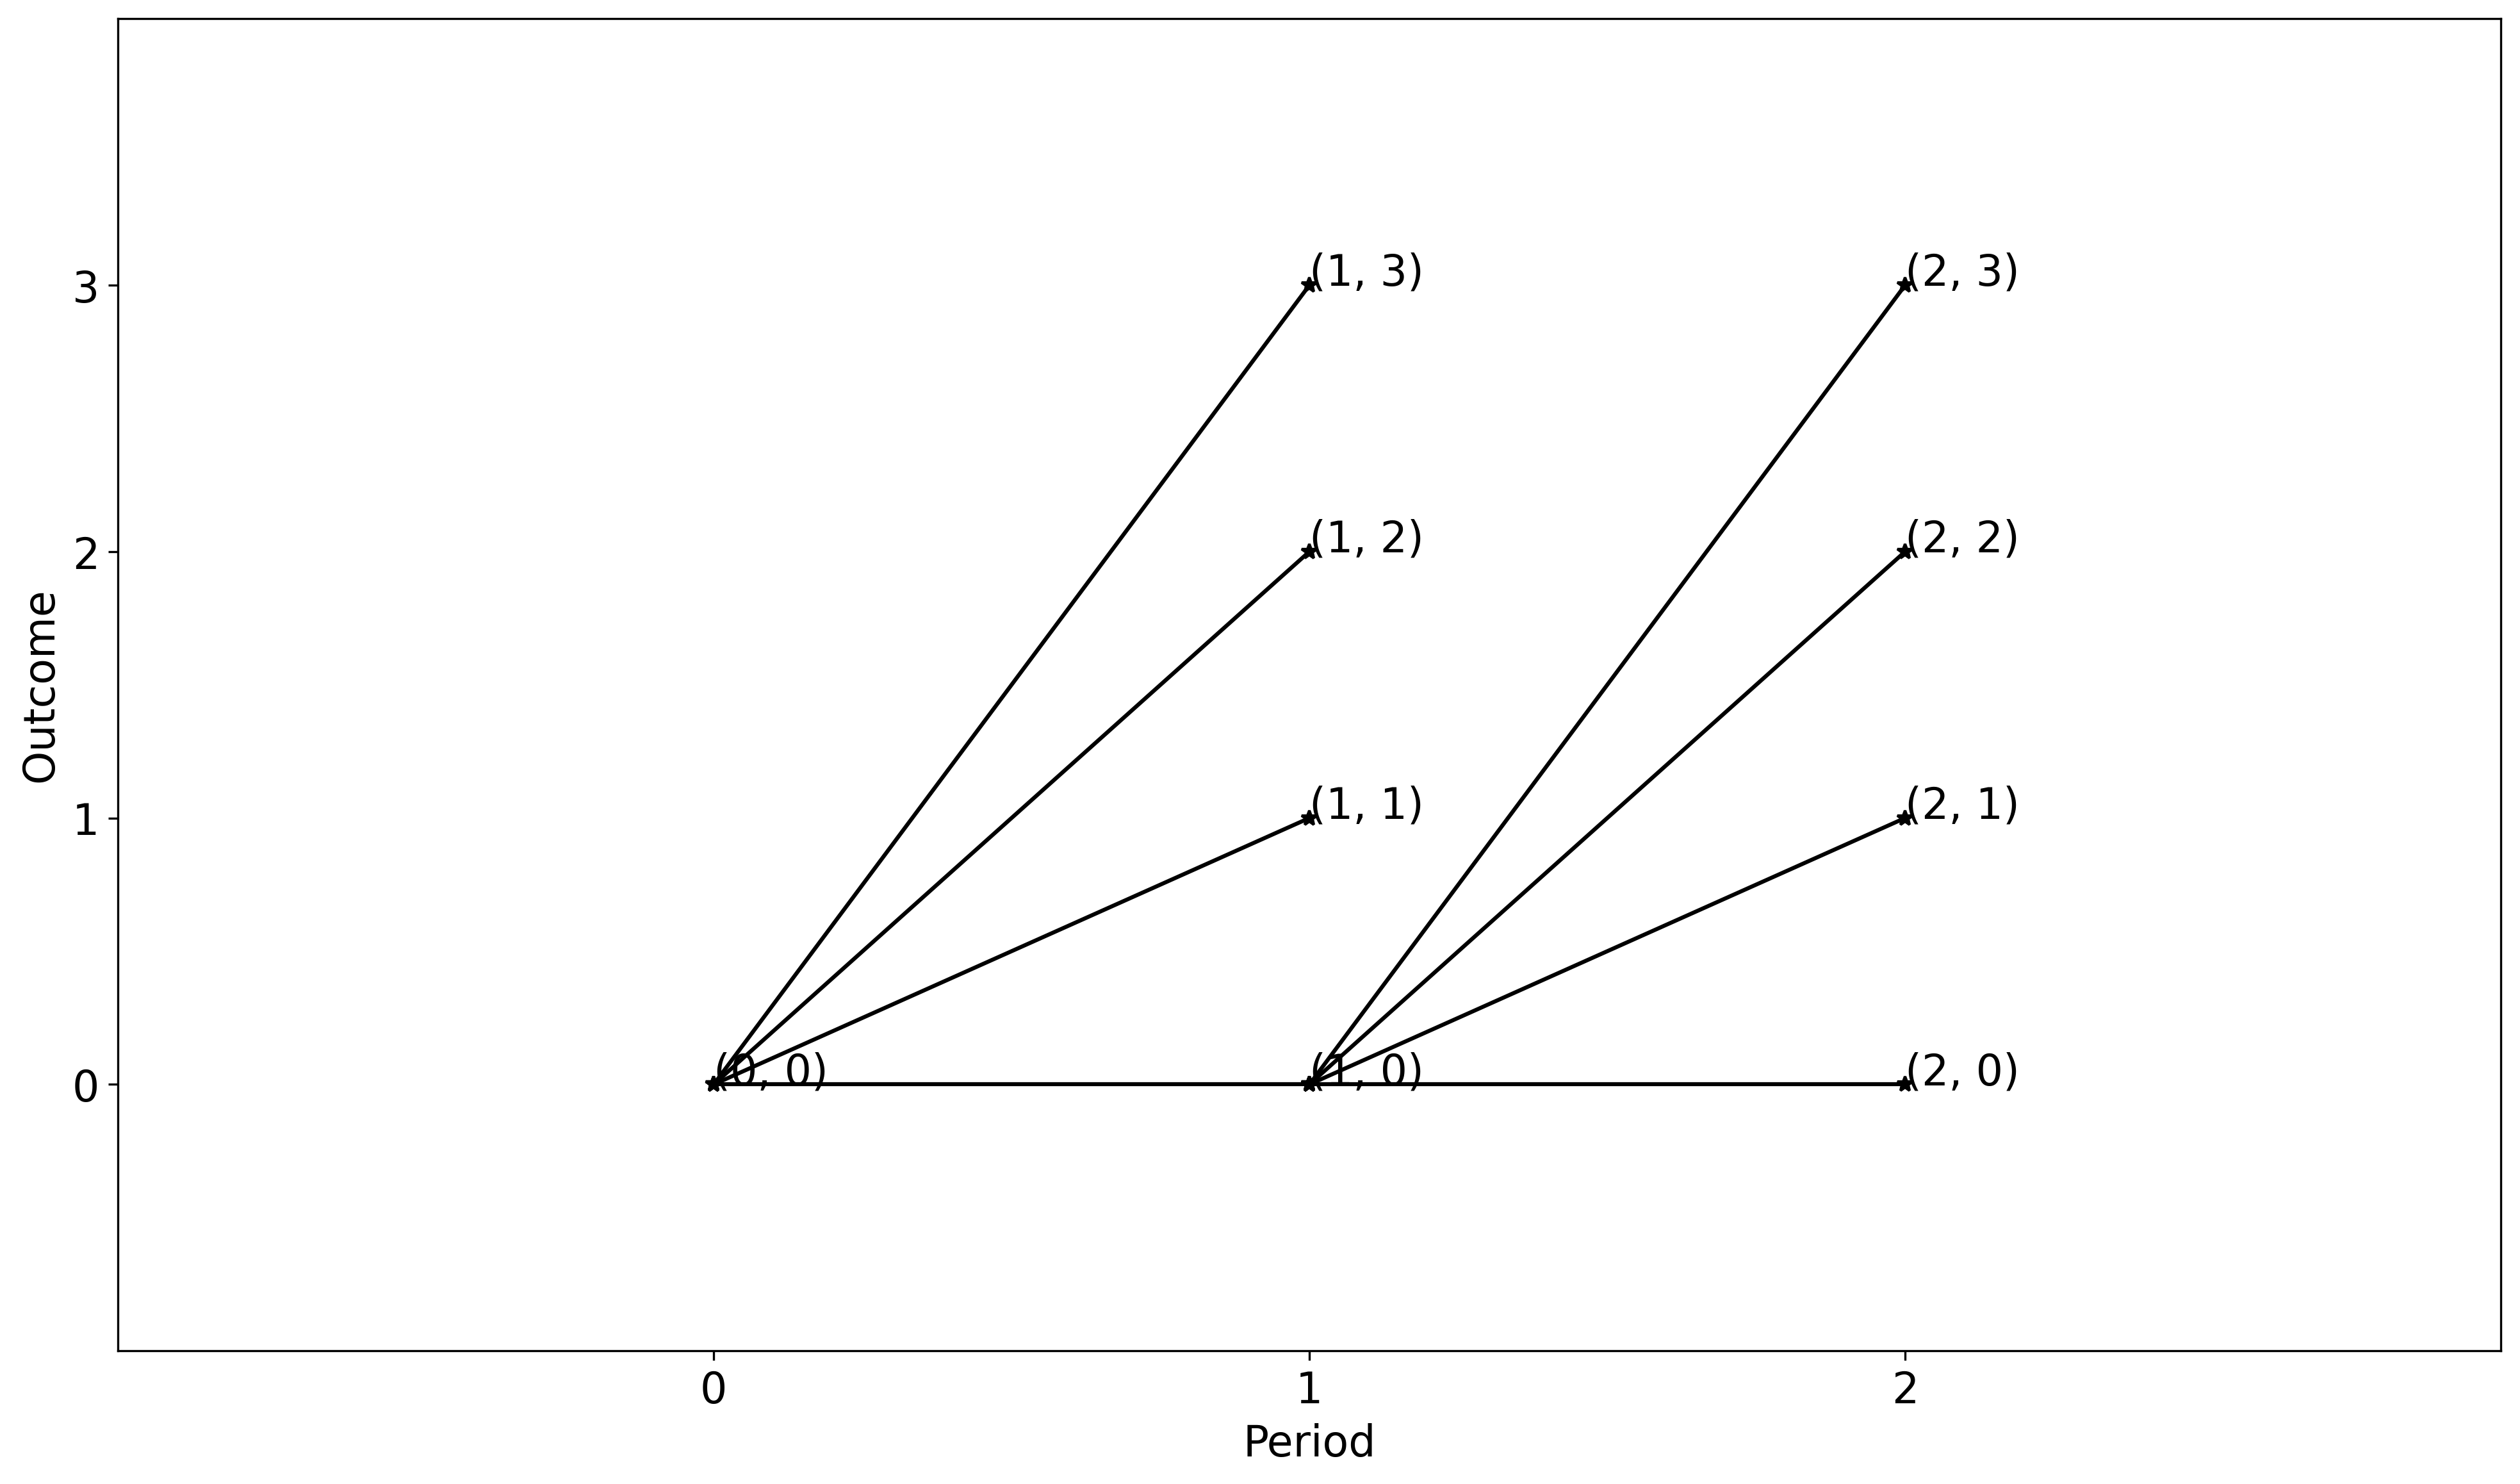

In [17]:
c = [[(0,0),(1,0)],[(0,0),(1,1)],[(0,0),(1,2)],[(0,0),(1,3)],[(1,0),(2,0)],[(1,0),(2,1)],[(1,0),(2,2)],[(1,0),(2,3)]]
fig = plt.figure()
ax = fig.add_subplot(111)
annotated = set()

for l in c:
    d = [[p[0] for p in l], [p[1] for p in l]]
    ax.plot(d[0], d[1], 'k-*')
    for p in l:
        annotated.add(p)

for p in annotated:
    ax.annotate(str(p), xy=p)

plt.xlabel('Period')
plt.xlim([-1, 3])
plt.xticks([0, 1, 2])
plt.ylabel('Outcome')
plt.ylim([-1, 4])
plt.yticks([0, 1, 2, 3])
plt.show()    

#### Default Events

There are many events that if one or more than 1 of them occur then we can recognize as the defaults event of borrowers: DPD30/60/90, bankruptcy, collateral owned by a bank, loan liquidation, foreclosure, etc.

For our data `default_time` $D_{it} = 1$ if the borrower $i$ default at time $t$, 0 otherwise.

#### Payoff Events

`payoff_time` $P_{it} = 1$ if the borrower $i$ pays the loan off at time $t$, 0 otherwise. He/she may take a new loans but can be consider as new entity. We estimate prob of payoff event (PP) like PD.

#### Loss Rates Given Default

$LGD_{it} = (EAD_{it} - EWCF_{Tr}) / EAD_{it}$ in which $EWCF_{Tr}$ is Expected Workout Cash Flow in resolution period $T$ at discount rate $r$.

We also use recovery rates $RR_{it} = 1 - LGD_{it}$

#### Exposure Conversion Measures

Exposure conversion measures are based on the ratio of future exposure (FE, in some instances relative to the expected exposure EE) denominated by a control for loan size.

### Default Engineering

#### Time-Vintage-Age (TVA) Analysis

Time

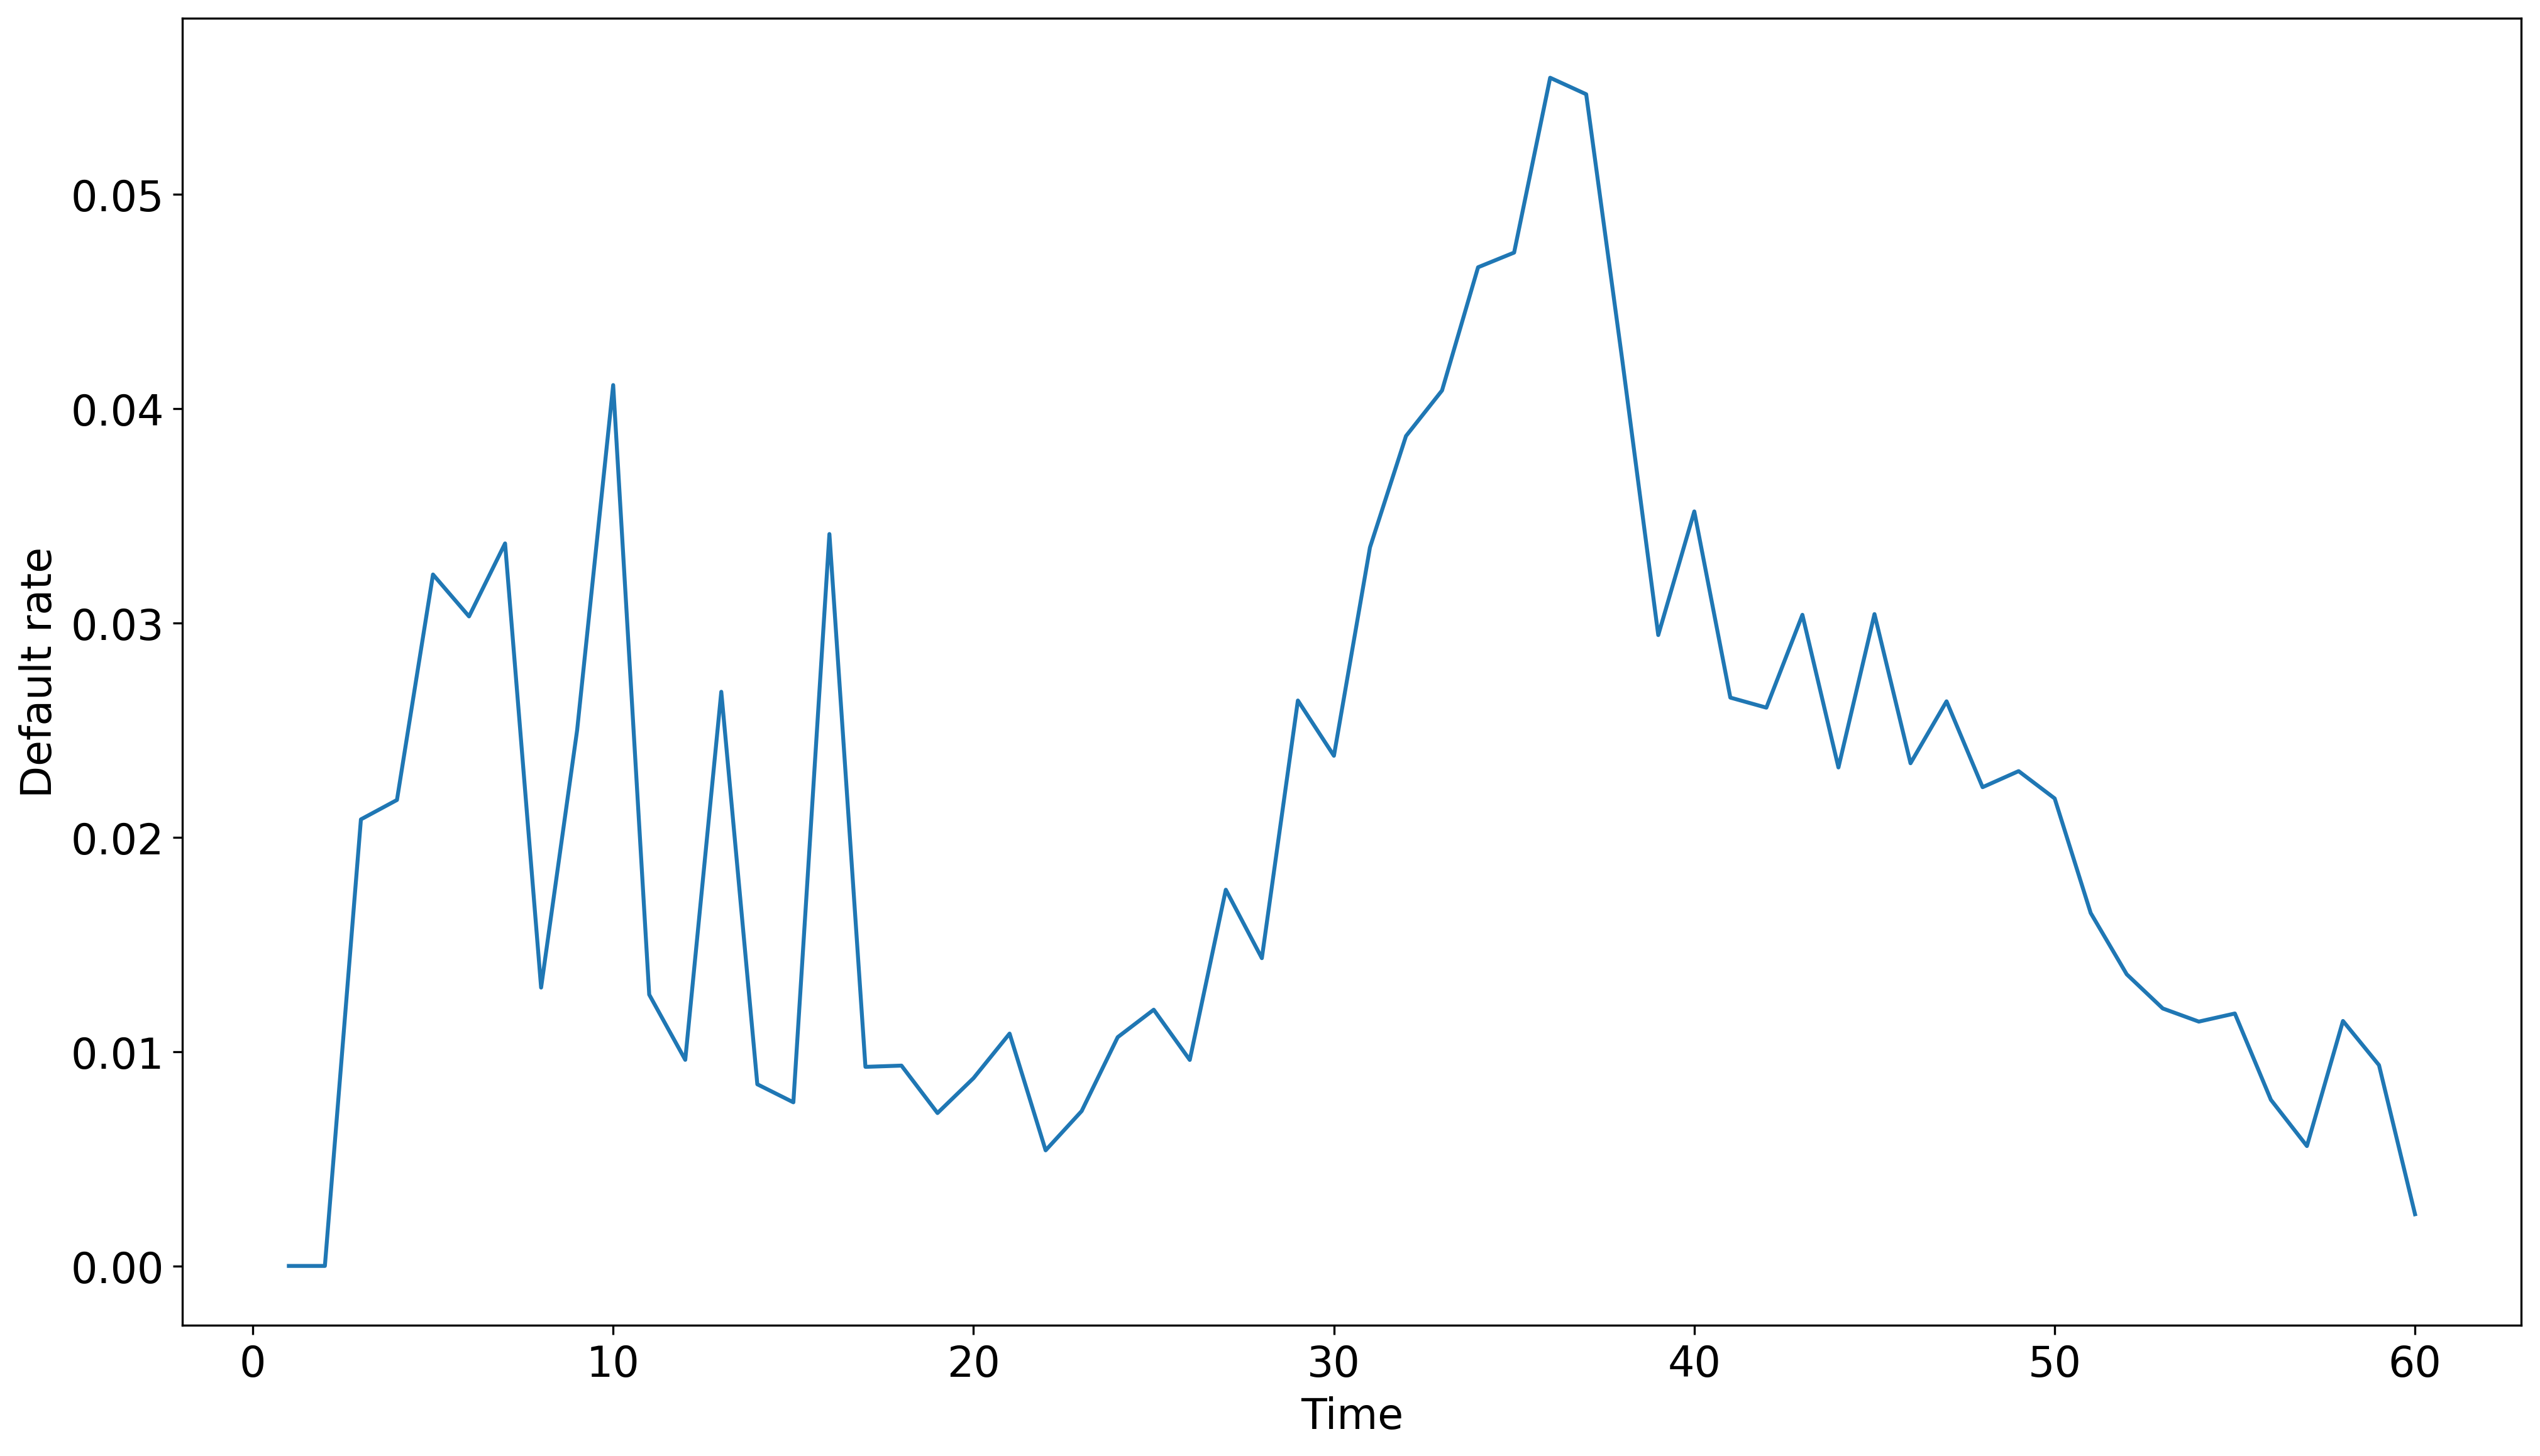

In [18]:
# default rate by time
default_rate = data.groupby('time')['default_time'].mean().reset_index(drop=False)
# plot it
plt.plot('time', 'default_time', data=default_rate)
plt.xlabel('Time')
plt.ylabel('Default rate')
plt.show()

Vintage (lending condition at loan originations - demand for credit / applied limit and supply of credit)

**Vintage effect is not considered in this book but readers are encouraged to include it in the model in practice.**

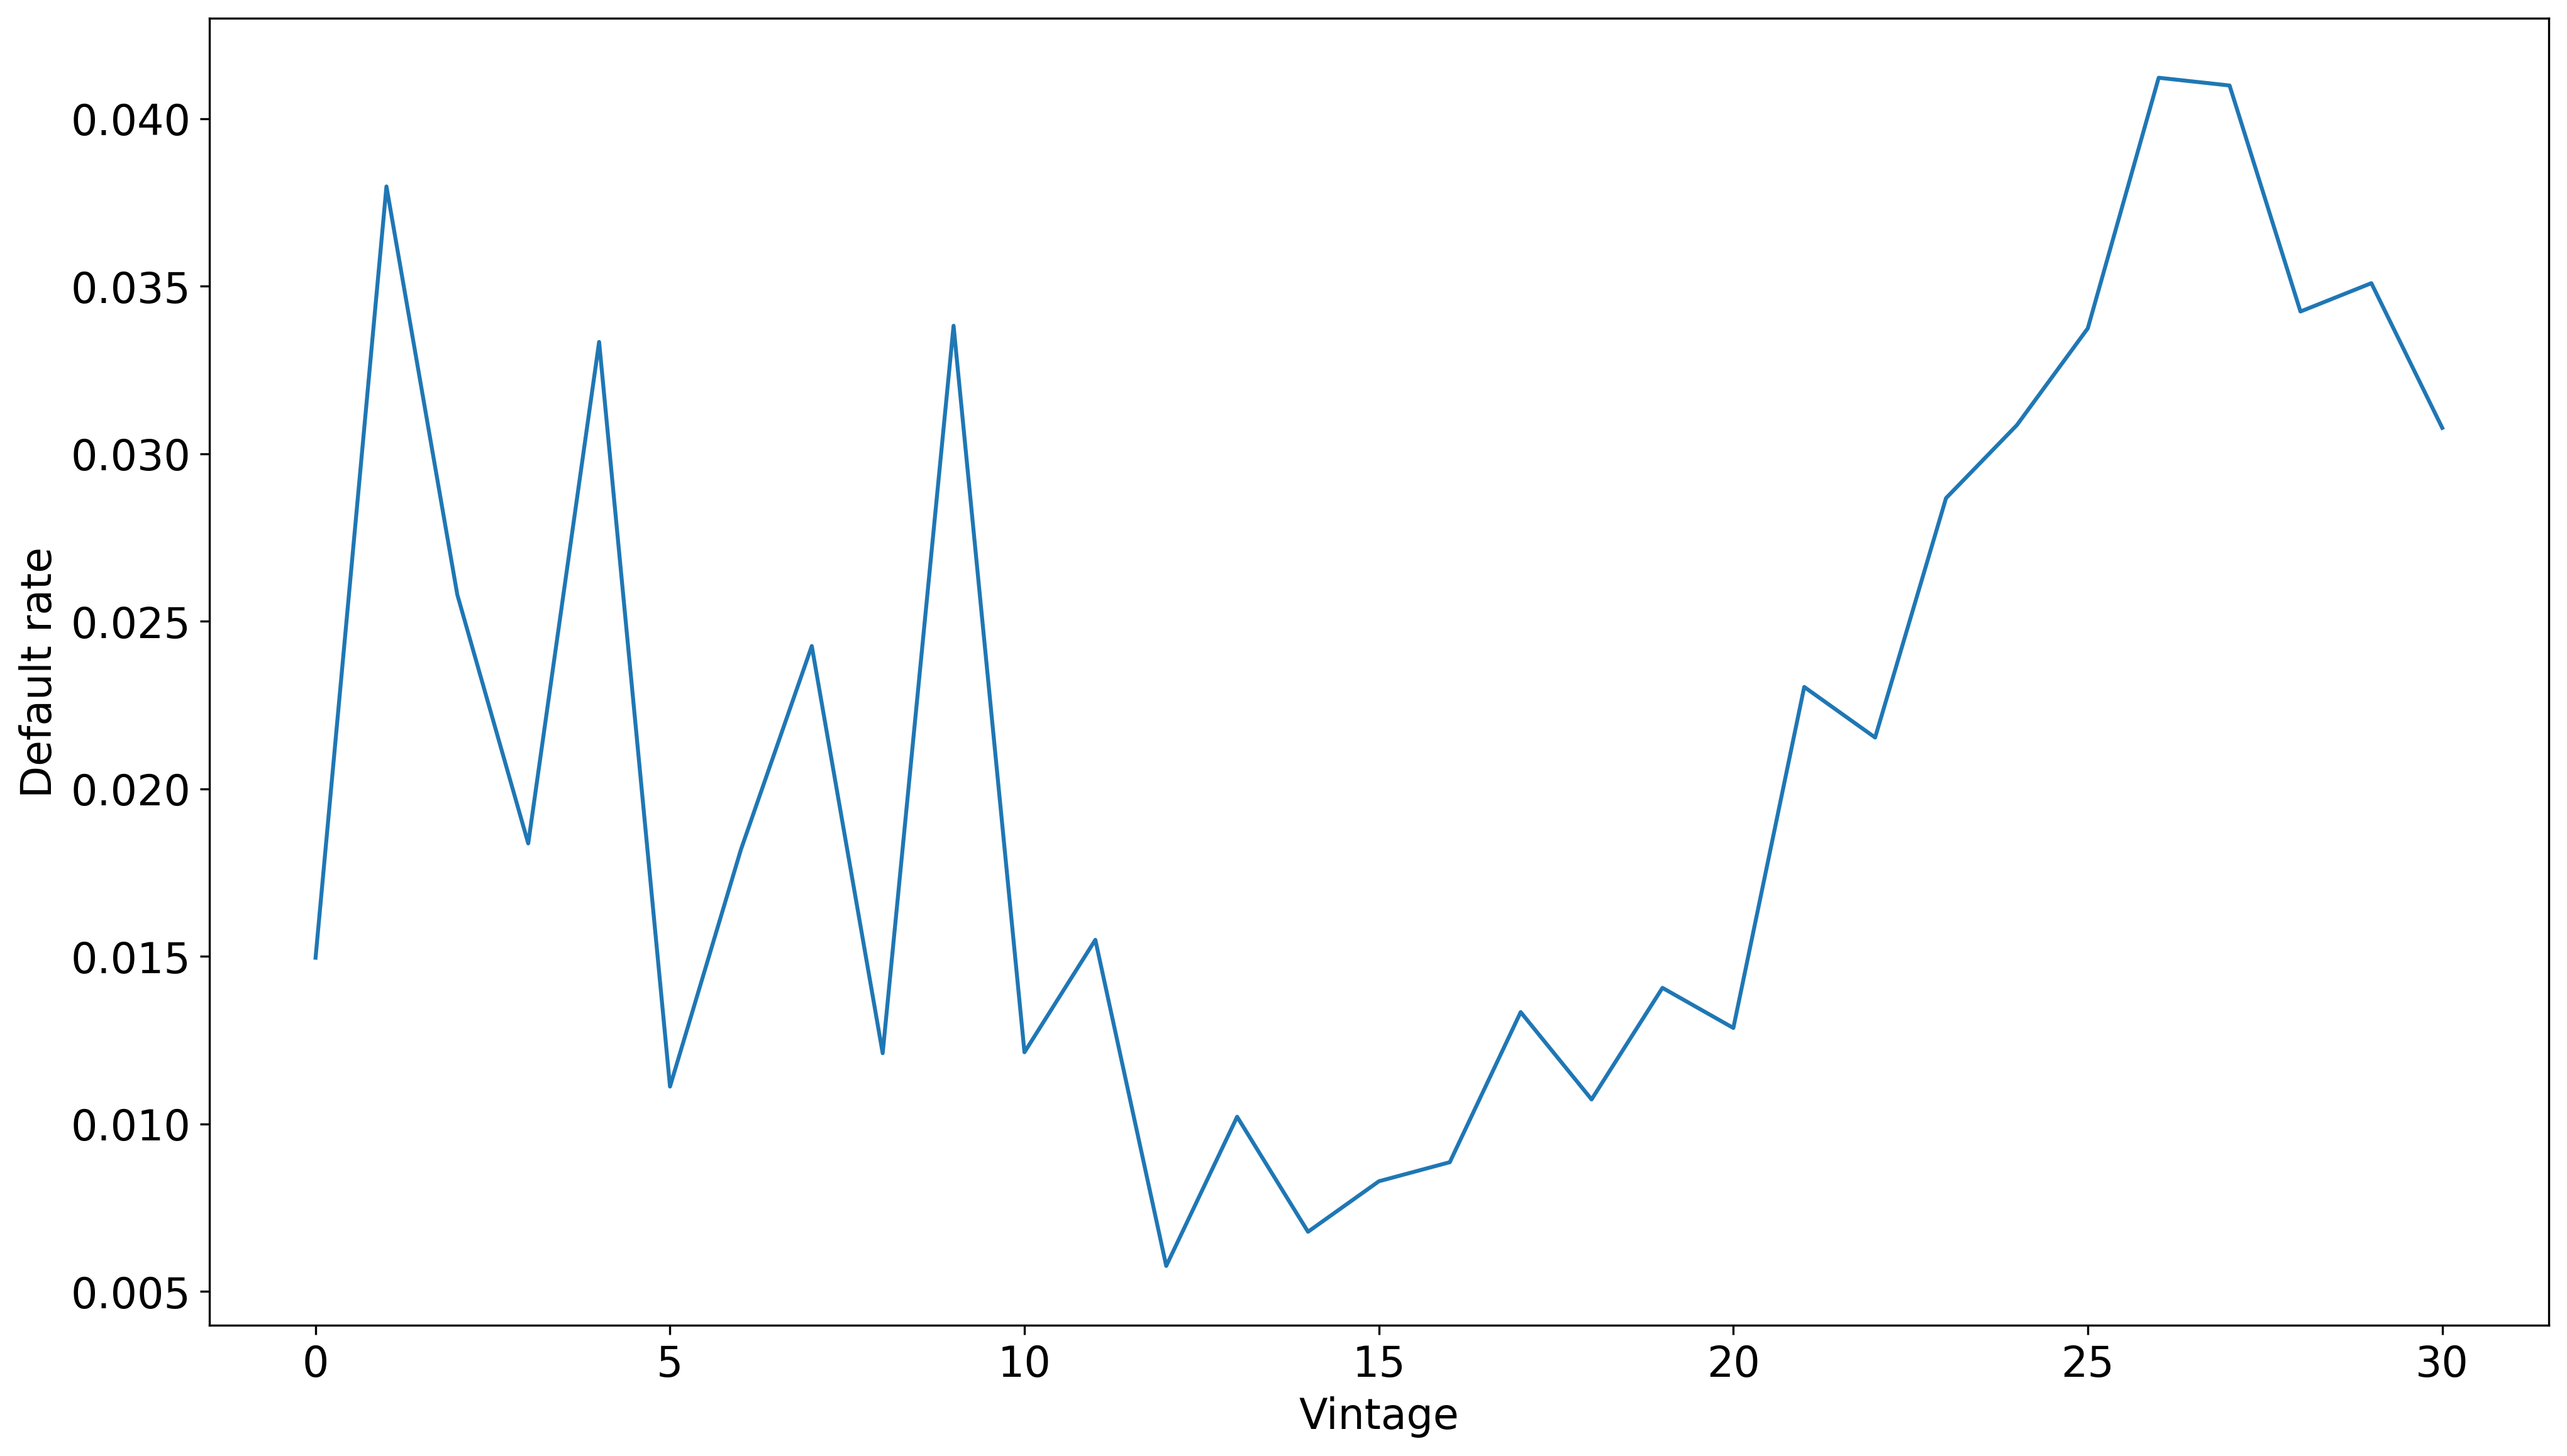

In [19]:
# since only a few loans are observed for period < 0 and > 30, we winsorize it.
data.loc[:,'orig_time2'] = data.orig_time
data.loc[data['orig_time2'] < 0, 'orig_time2'] = 0
data.loc[data['orig_time2'] >= 30, 'orig_time2'] = 30
default_rate = data.groupby('orig_time2')['default_time'].mean().reset_index(drop=False)

plt.plot('orig_time2', 'default_time', data=default_rate)
plt.xlabel('Vintage')
plt.ylabel('Default rate')
plt.show()
# increase from vintage 15

Age

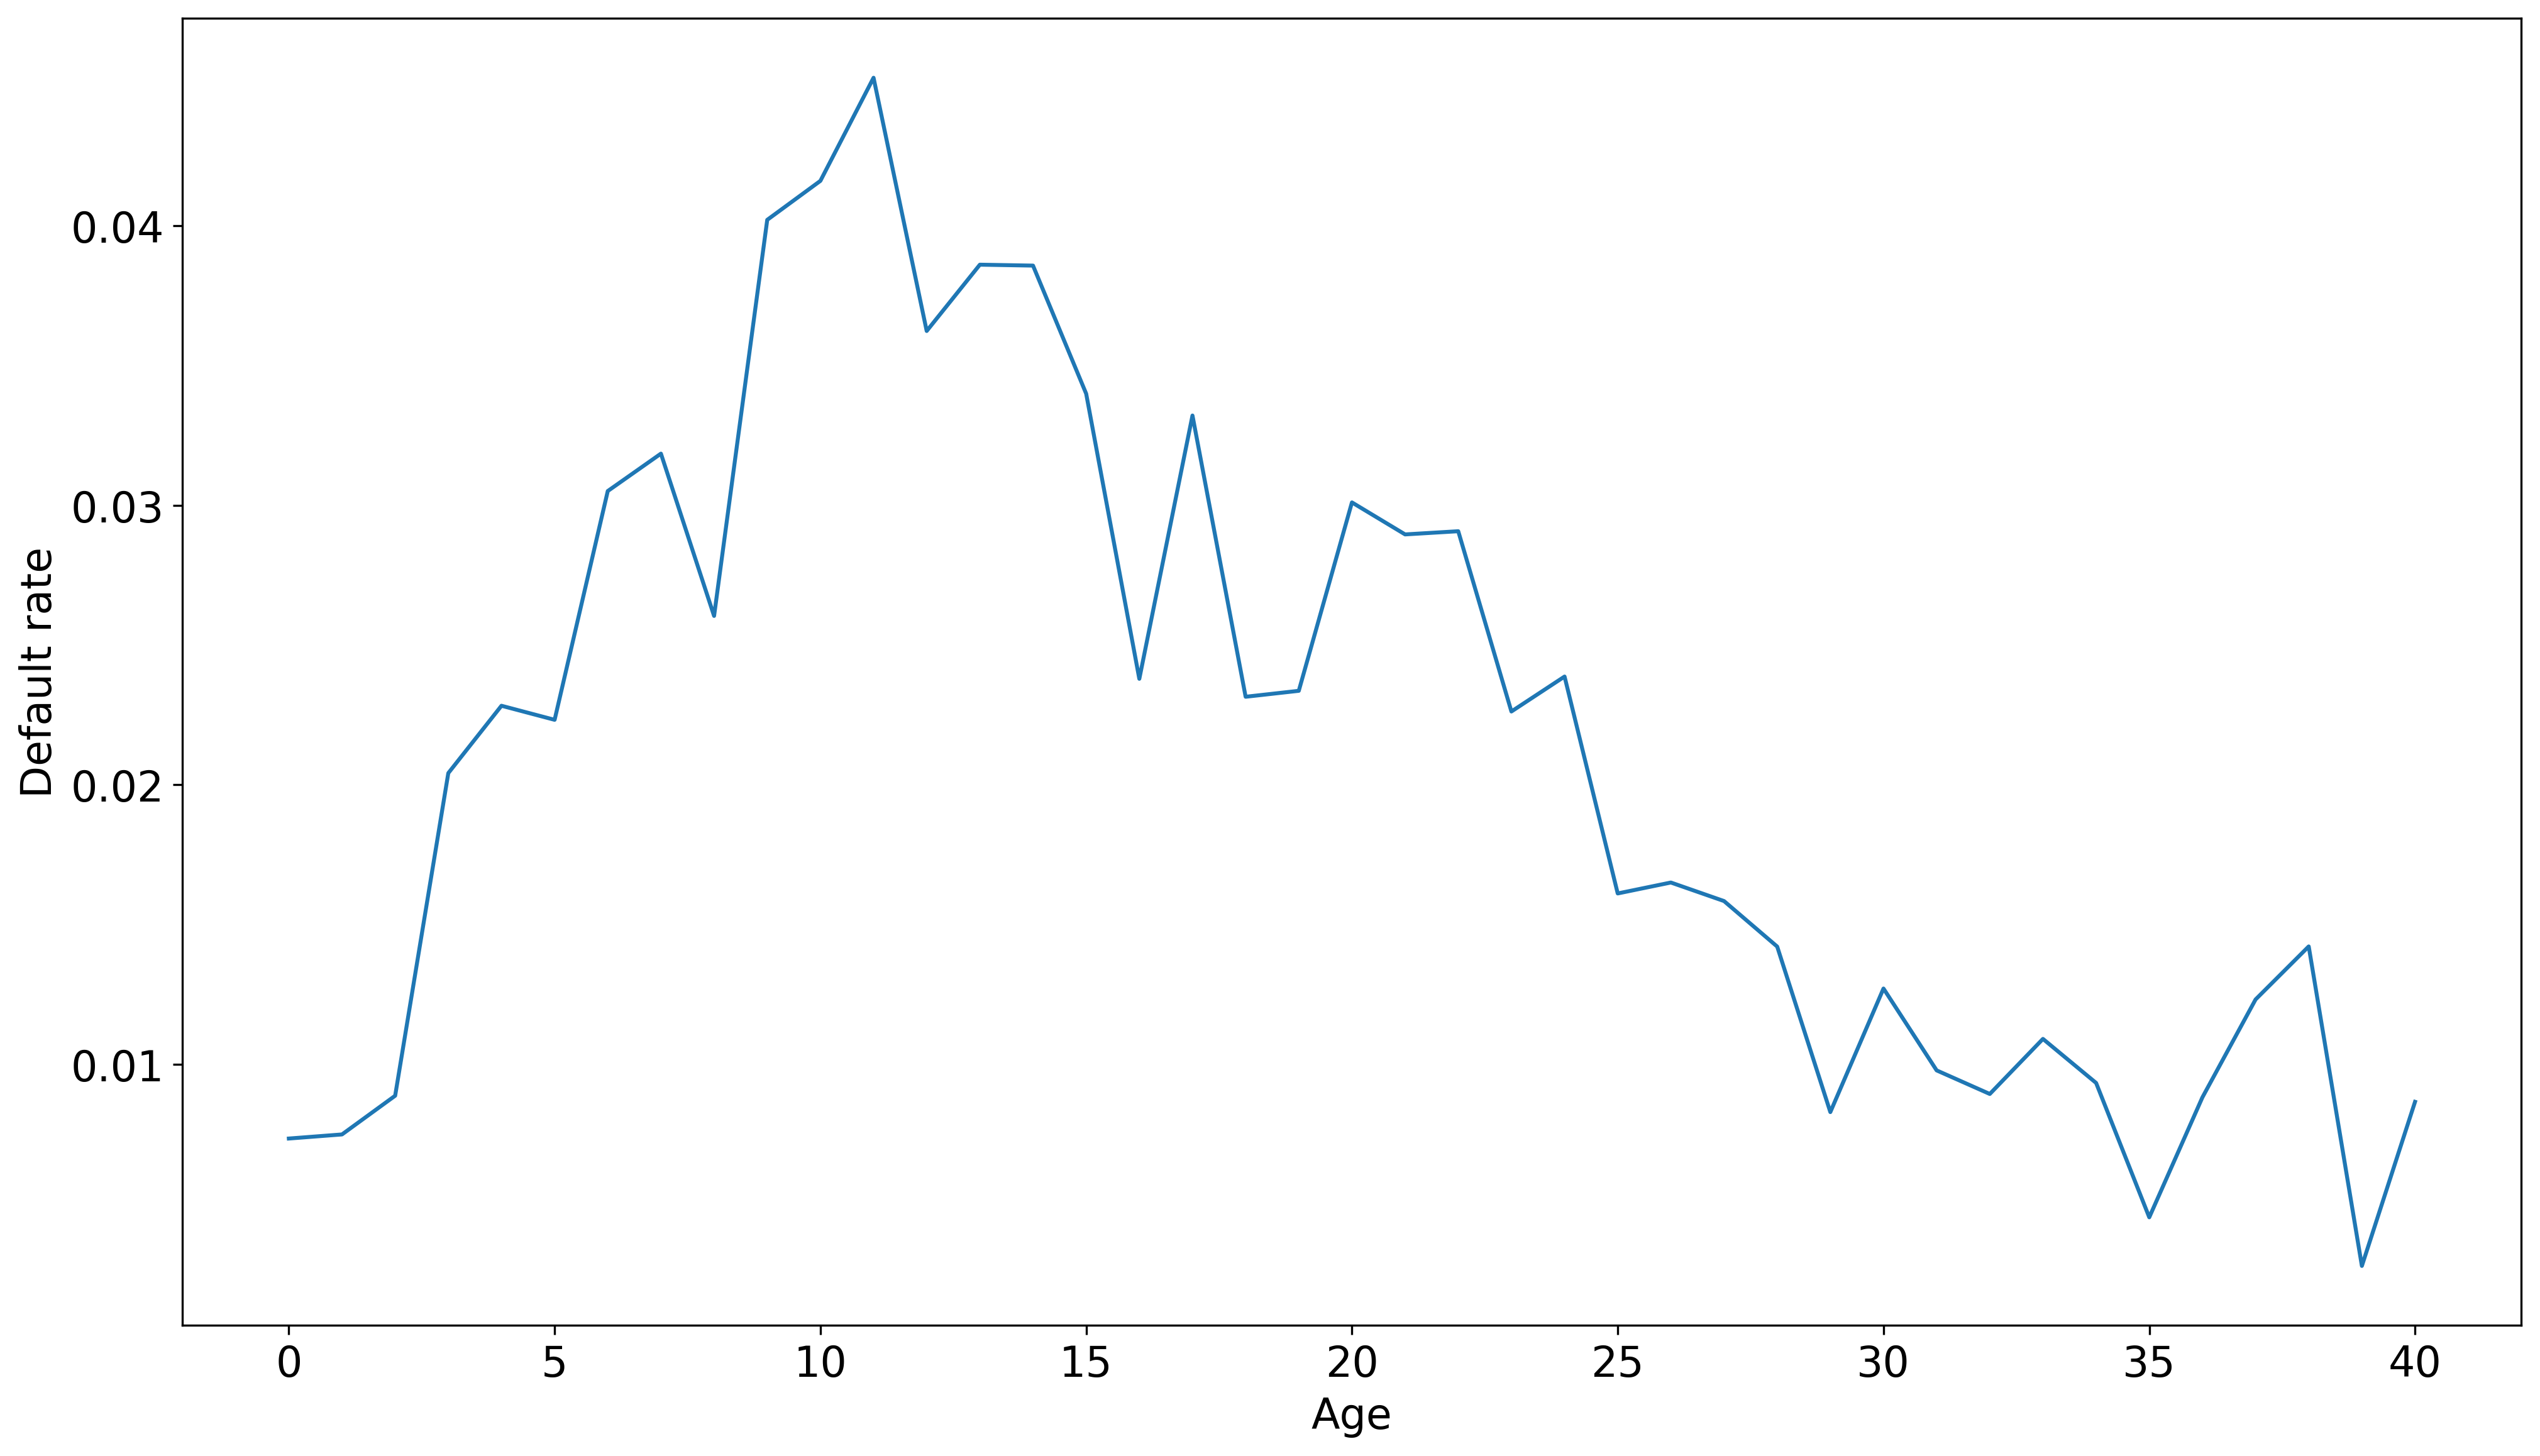

In [20]:
data.loc[:,'age'] = data.loc[:,'time']-data.loc[:,'orig_time']
data.loc[data['age'] >= 40, 'age'] = 40
data_mean_age = data.groupby('age')['default_time'].mean().reset_index(drop=False)

plt.plot('age', 'default_time', data=data_mean_age)
plt.xlabel('Age')
plt.ylabel('Default rate')
plt.show()

#### Multi-Lead Analysis

Some kind of lag/lead analysis

In [21]:
data = data.sort_values(by=['id', 'time'])
data.loc[:,'default_time_1'] = data.groupby(['id'])['default_time'].shift(-1)
data.loc[:,'default_time_2'] = data.groupby(['id'])['default_time'].shift(-2)
print(data.loc[(data.id == 9)|(data.id == 47),['id', 'time', 'default_time', 'default_time_1', 'default_time_2']])

    id  time  default_time  default_time_1  default_time_2
35   9    25             0             0.0             0.0
36   9    26             0             0.0             0.0
37   9    27             0             0.0             0.0
38   9    28             0             0.0             0.0
39   9    29             0             0.0             0.0
..  ..   ...           ...             ...             ...
46   9    36             0             1.0             NaN
47   9    37             1             NaN             NaN
48  47    25             0             0.0             0.0
49  47    26             0             0.0             NaN
50  47    27             0             NaN             NaN

[16 rows x 5 columns]


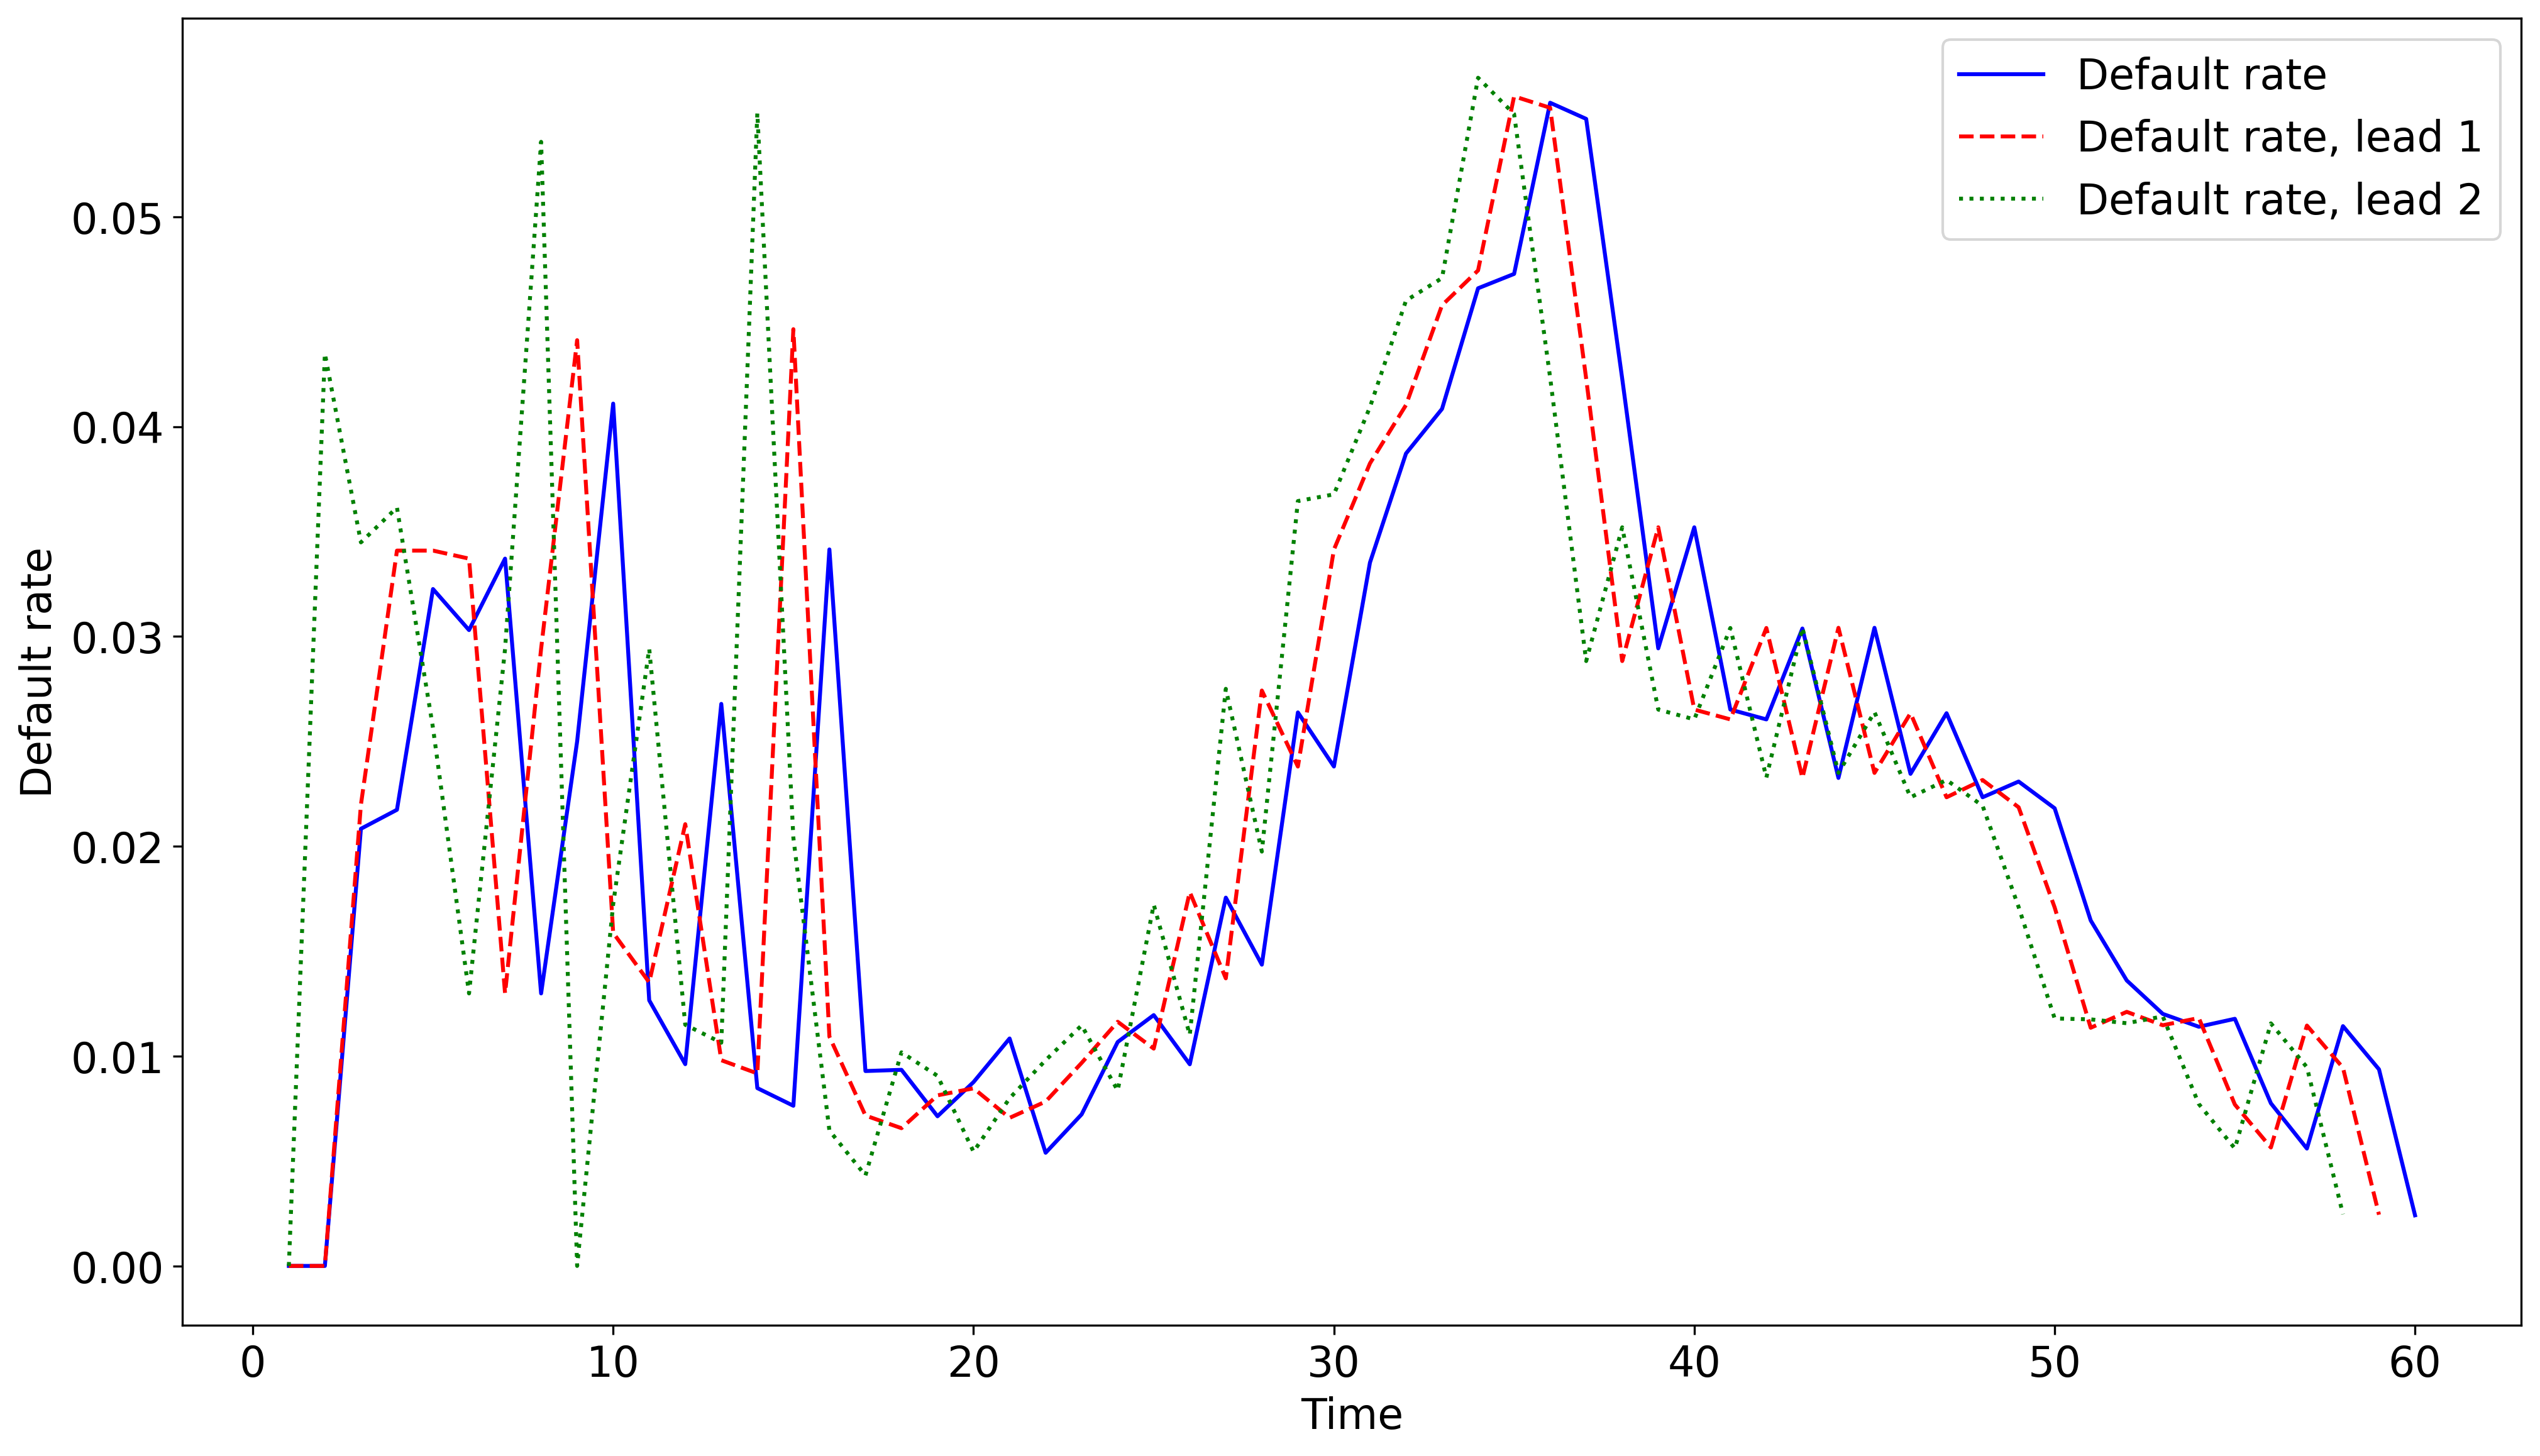

In [22]:
default_rate = data.groupby('time')['default_time'].mean().reset_index(drop=False)
default_rate_1 = data.groupby('time')['default_time_1'].mean().reset_index(drop=False)
default_rate_2 = data.groupby('time')['default_time_2'].mean().reset_index(drop=False)
plt.plot('time', 'default_time', data=default_rate, color='blue', label='Default rate')
plt.plot('time', 'default_time_1', data=default_rate_1, color='red', label='Default rate, lead 1', ls='dashed')
plt.plot('time', 'default_time_2', data=default_rate_2, color='green', label='Default rate, lead 2', ls='dotted')
plt.xlabel('Time')
plt.ylabel('Default rate')
plt.legend(loc='best')
plt.show()

#### Multi-Period Analysis

important for CECL/IFRS 9 loan loss provisioning, economic capital and loan pricing -> **cumulative default rate** is commonly used. It's lifetime default rate if time is
measured to maturity.

$$\mathrm{CDR}{t+\Delta t} = \mathrm{DR}t + \sum{s=0}^{\Delta t-1} \mathrm{DR}{t+\Delta s} \left(1 - \mathrm{DR}_{t+\Delta s}\right)$$

This equation expresses the cumulative default rate (CDR) at time $t+\Delta t$ as the sum of the default rate at time $t$ and the weighted default rates in each period from $t$ to $t+\Delta t-1$, where the weights are the survival rates (1 minus the default rates) in each respective period.
The summation from $s=0$ to $\Delta t-1$ captures the iterative nature of the CDR calculation over the successive time periods.

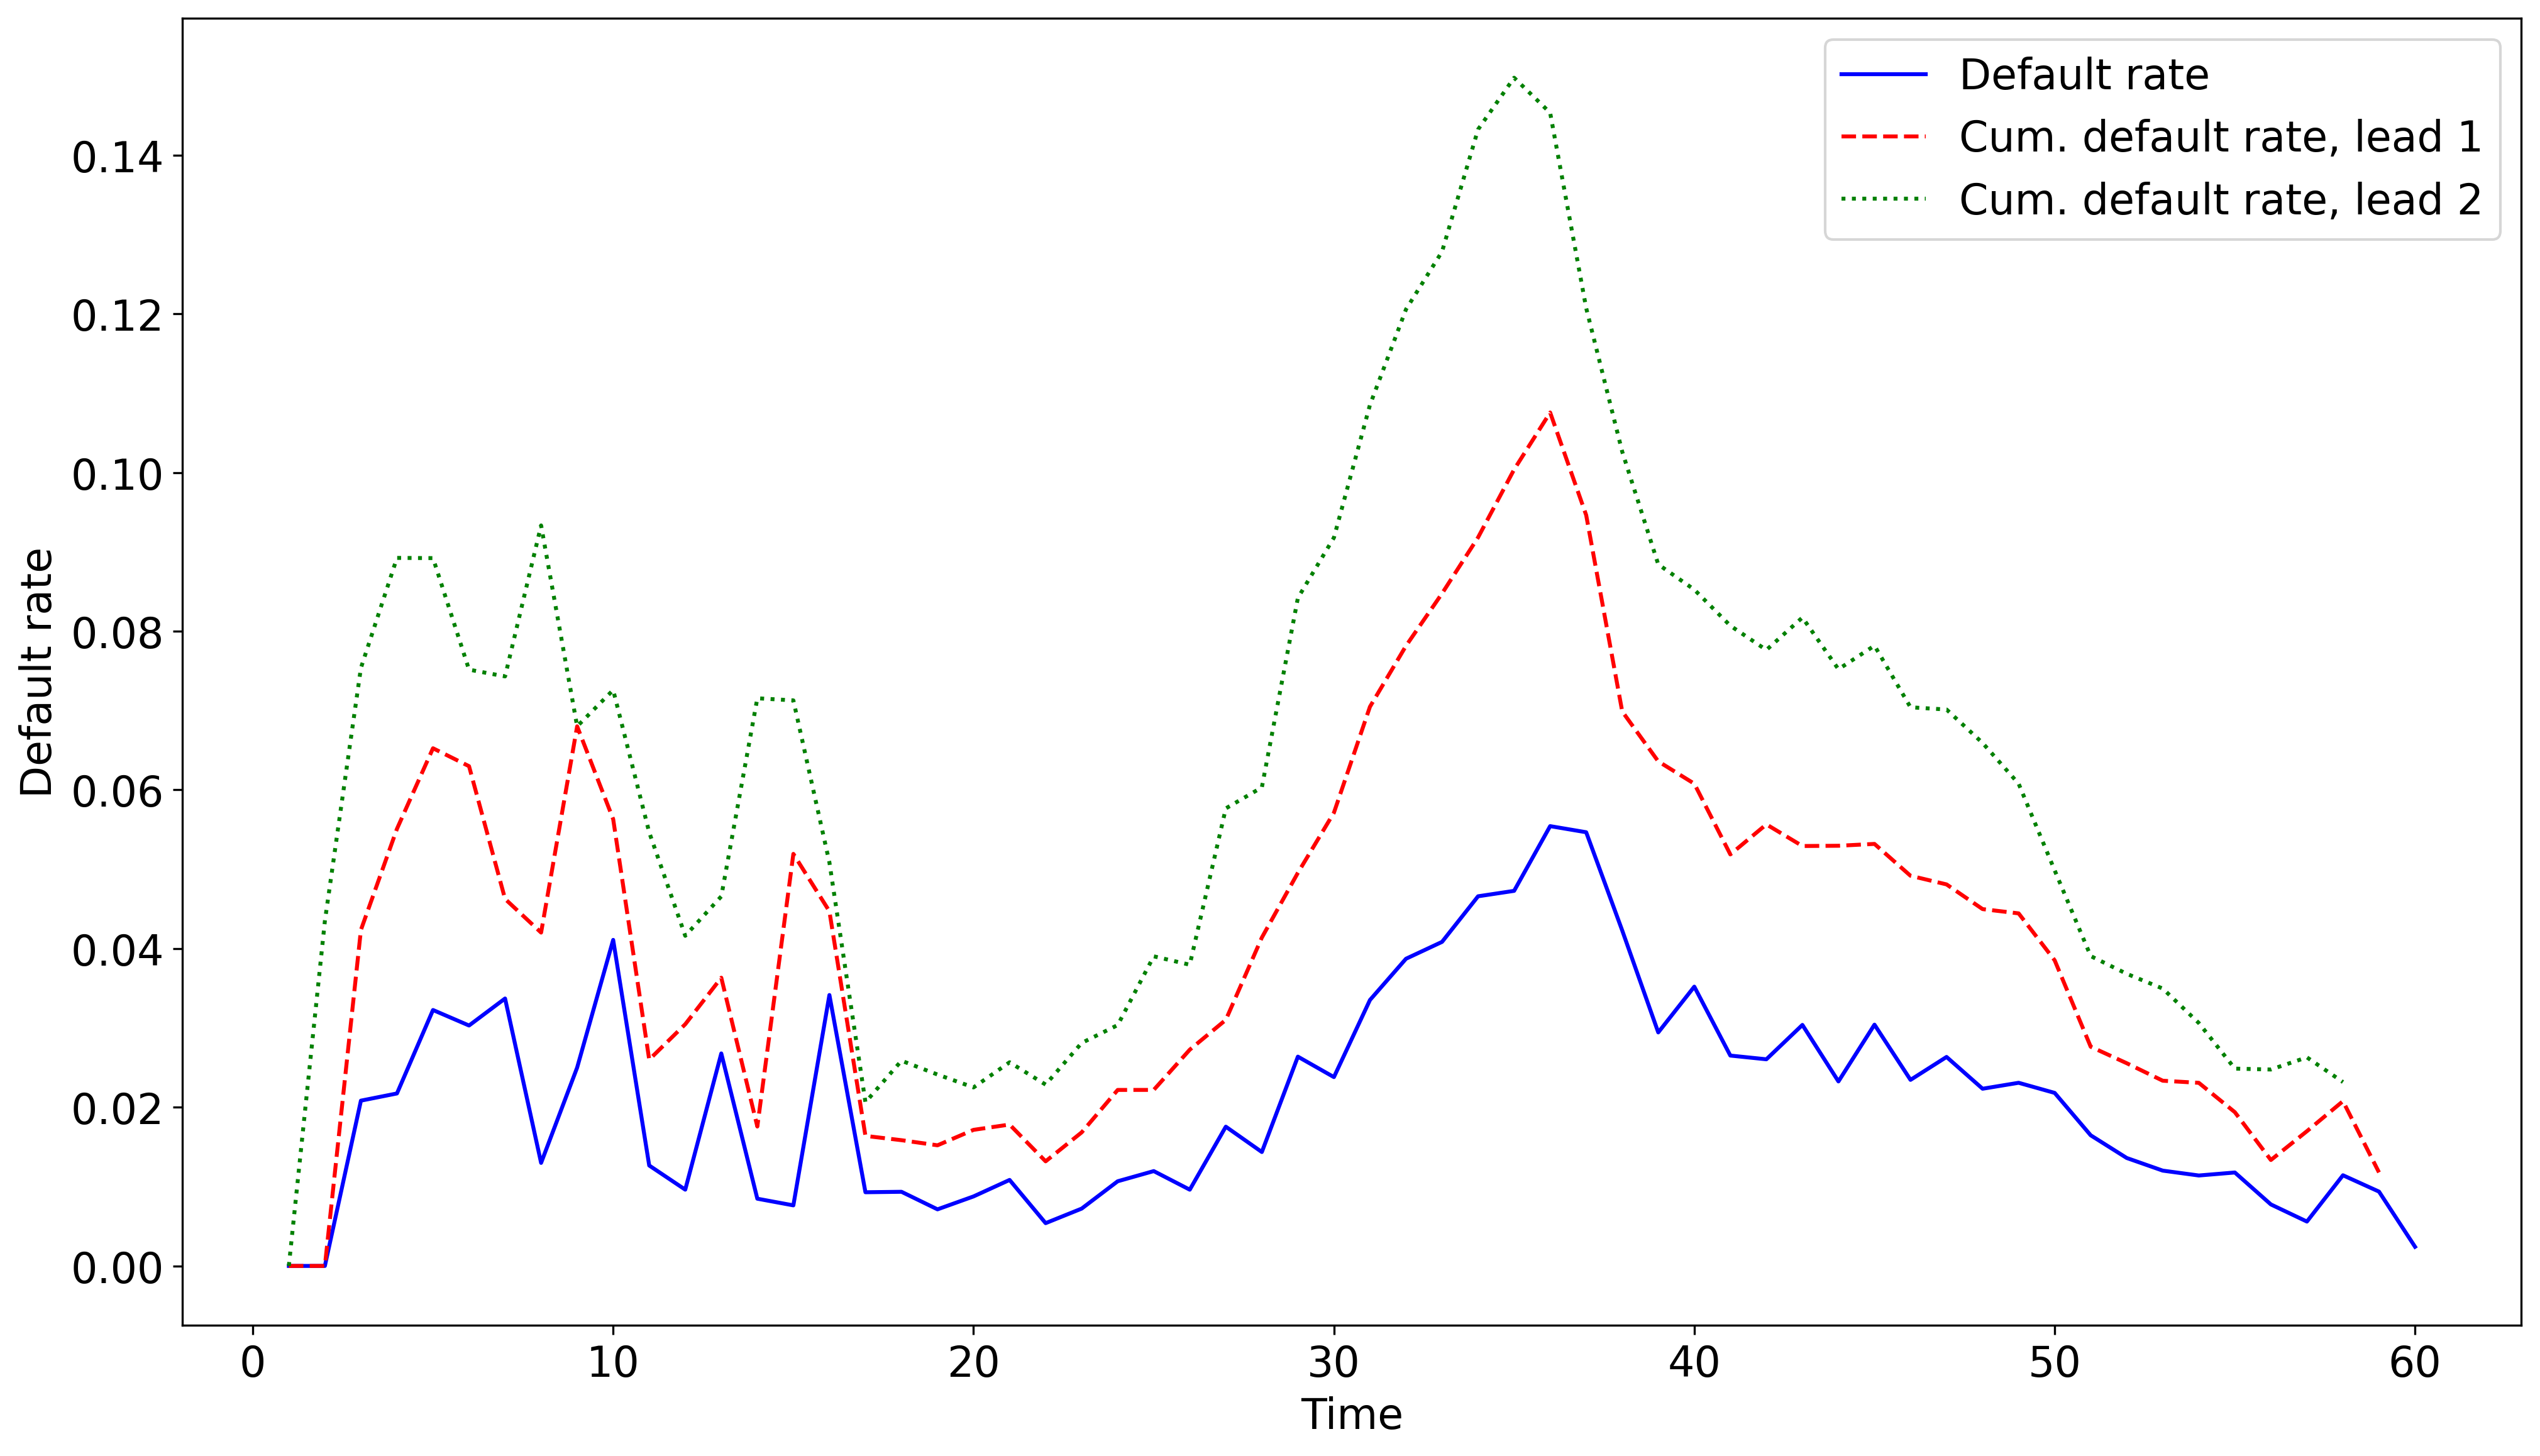

In [23]:
default_rate_1.loc[:,'cum_default_time_1'] = default_rate.loc[:,'default_time'] + (1-default_rate.loc[:,'default_time']) * default_rate_1.loc[:,'default_time_1']
default_rate_2.loc[:,'cum_default_time_2'] = default_rate.loc[:,'default_time'] + (1-default_rate.loc[:,'default_time']) * default_rate_1.loc[:,'default_time_1'] + (1-default_rate.loc[:,'default_time']) * (1-default_rate_1.loc[:,'default_time_1']) * default_rate_2.loc[:,'default_time_2']
plt.plot('time', 'default_time', data=default_rate, color='blue', label='Default rate')
plt.plot('time', 'cum_default_time_1', data=default_rate_1, color='red', label='Cum. default rate, lead 1', ls='dashed')
plt.plot('time', 'cum_default_time_2', data=default_rate_2, color='green', label='Cum. default rate, lead 2', ls='dotted')
plt.xlabel('Time')
plt.ylabel('Default rate')
plt.legend(loc='best')
plt.show()

### LGD Engineering

Outcomes after default event occurs:
- Cure: payback and return to performing;
- Restructuring: key loan term are modified;
- Liquidation, repossession or foreclosure: bank take full possession of the collateral assets.

This book focus on LGDs from liquidation/ workouts outcome. 2 stages:
1. Raw LGDs, considering workouts cashflow and discount rates;
2. Estimate the regression models for observed LGDs.

$LGD_{it} = (EAD_{it} - EWCF_{Tr}) / EAD_{it}$ in which $EWCF_{Tr}$ is Expected Workout Cash Flow in resolution period $T$ at discount rate $r$.

We also use recovery rates $RR_{it} = 1 - LGD_{it}$

Data Preliminaries

In [24]:
from dcr import dataprep

data,_,_,_,_,_,_ = dataprep(data)
data['PD'] = data['default_time'].mean()
data['default_time'].mean()

0.024880934221453873

Resolution Period

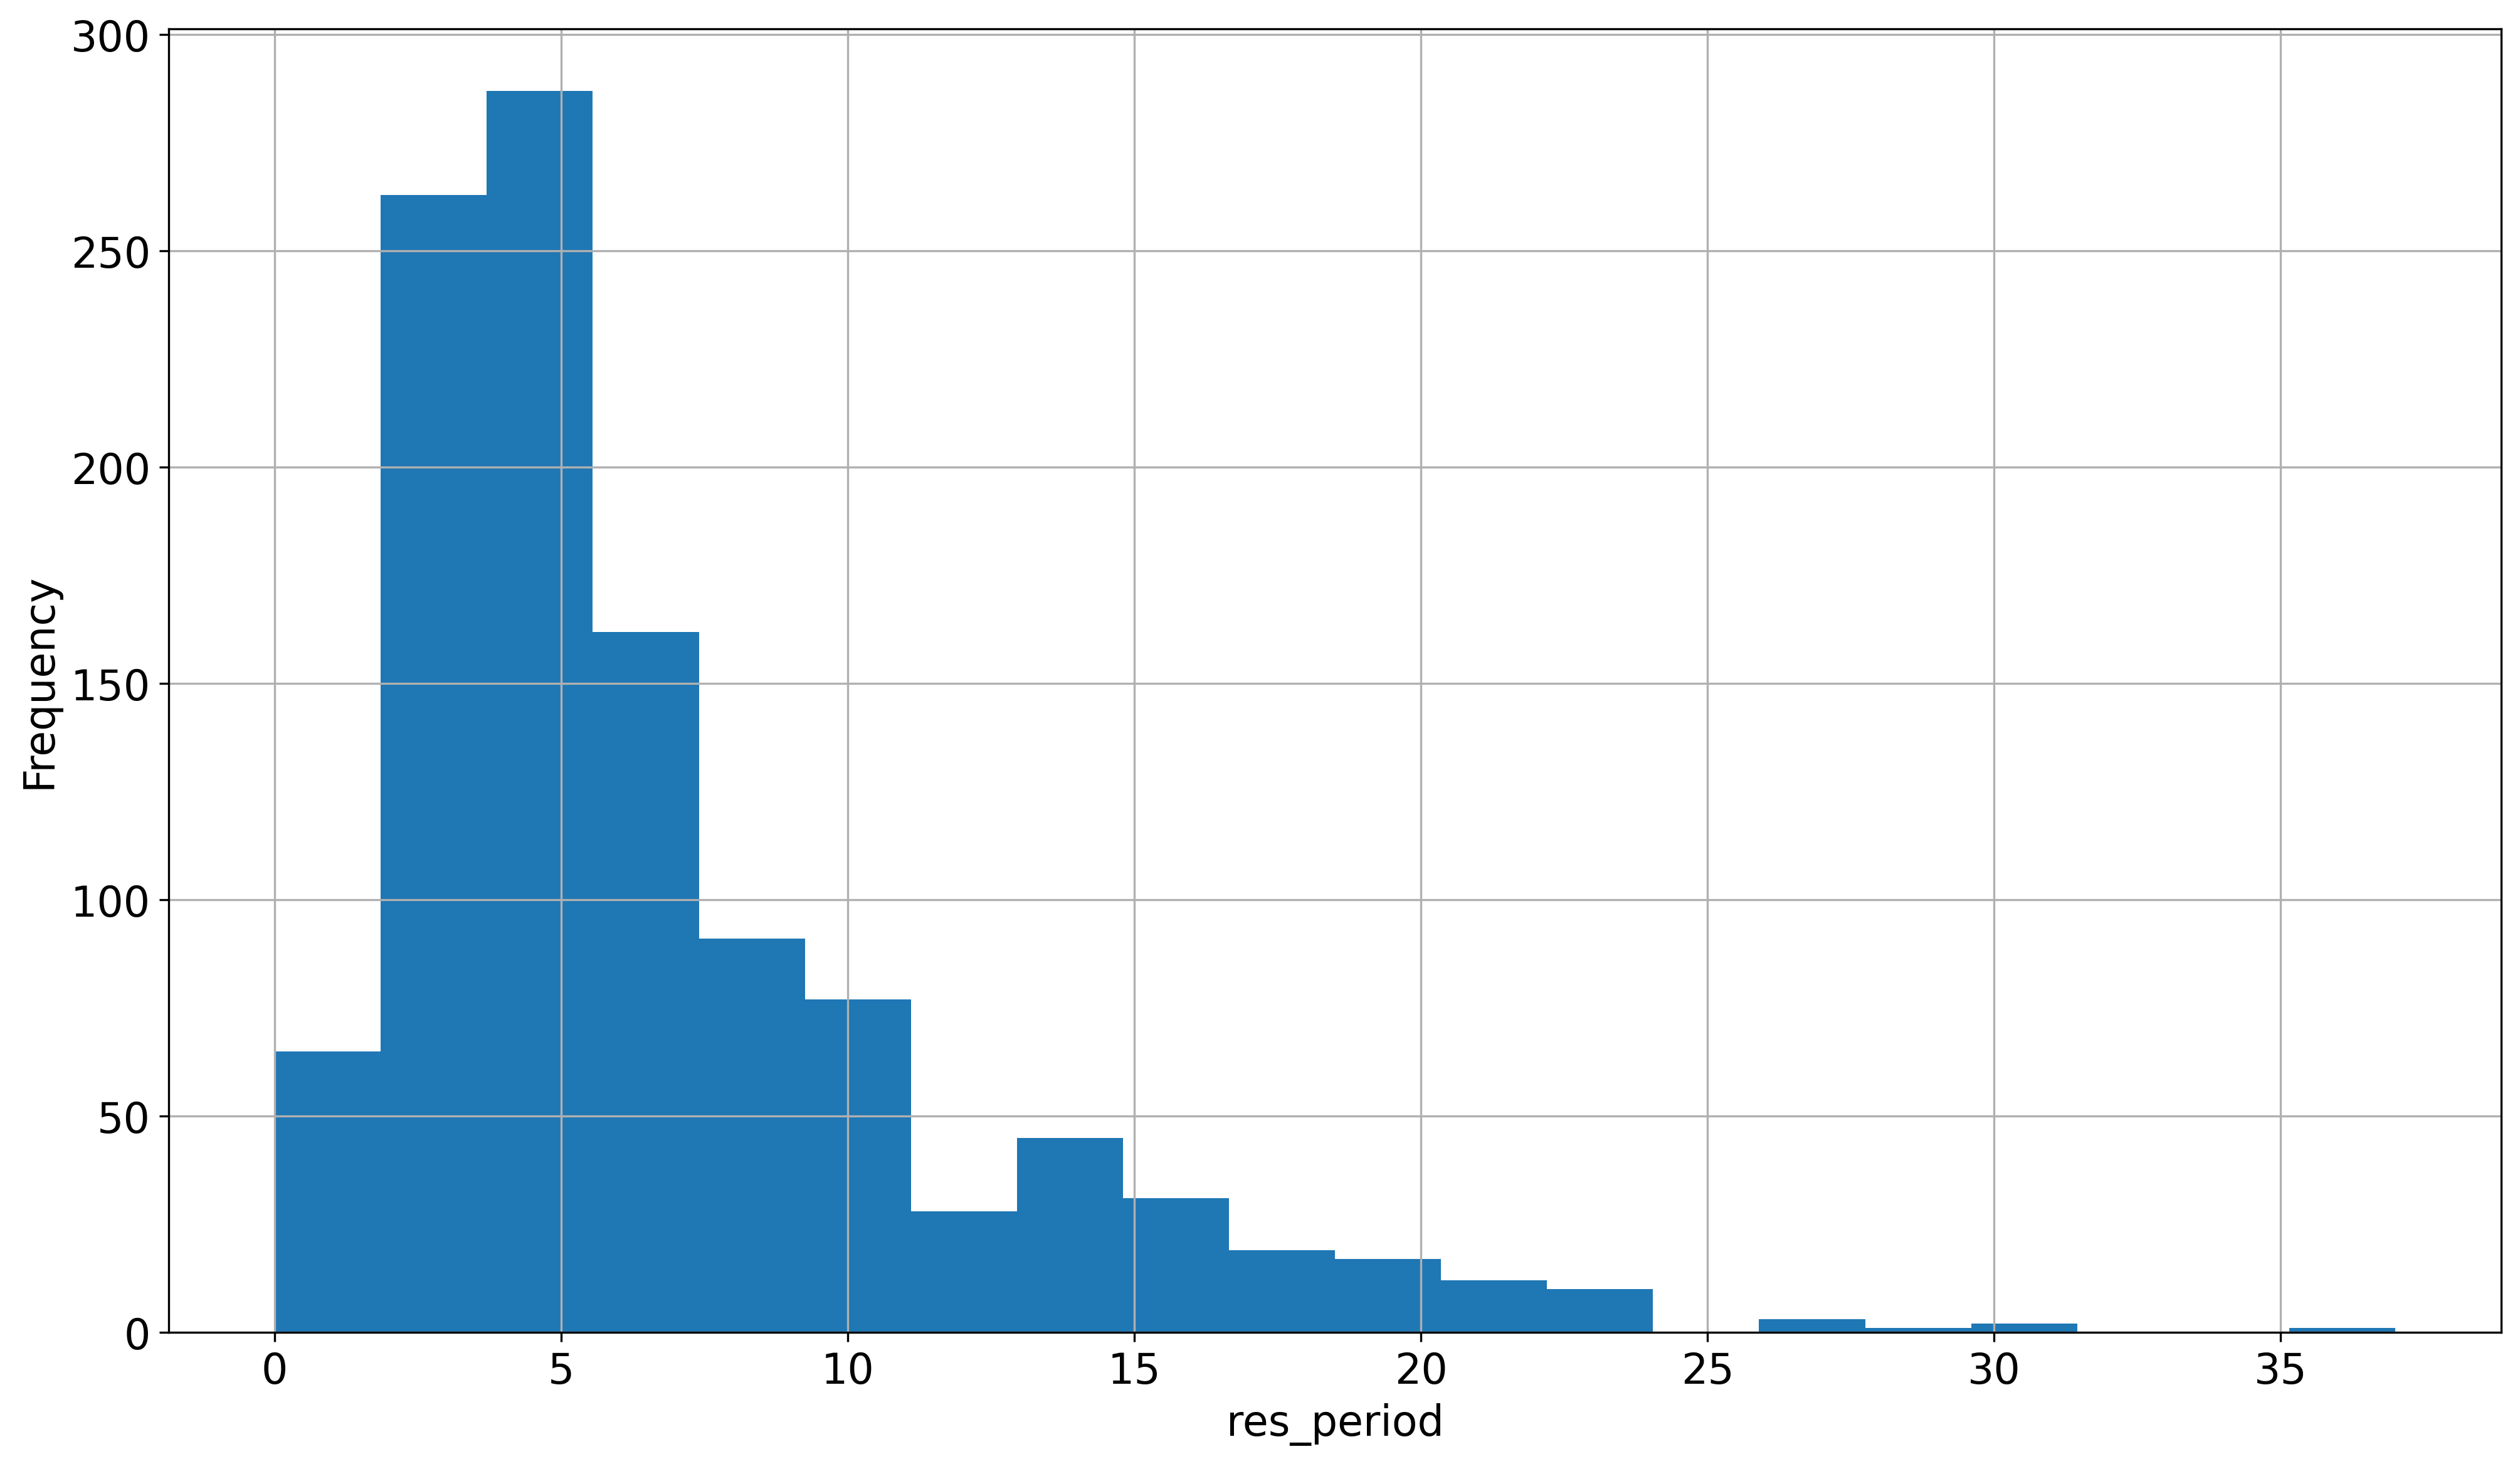

In [11]:
data_default = data.loc[data['default_time'] == 1,:].copy()
data_default.loc[:,'res_period'] = data_default.loc[:,'res_time'] - data_default.loc[:, 'time']
data_default.loc[:,'res_period'].hist(bins=20)
plt.xlabel('res_period')
plt.ylabel('Frequency')
plt.show()

In [12]:
print(data_default.loc[:,'res_period'].describe().round(decimals=2))

count    1114.00
mean        6.64
std         5.11
min         0.00
25%         3.00
50%         5.00
75%         8.00
max        37.00
Name: res_period, dtype: float64


Risk-Free LGD from Observed Workout Cash Flows

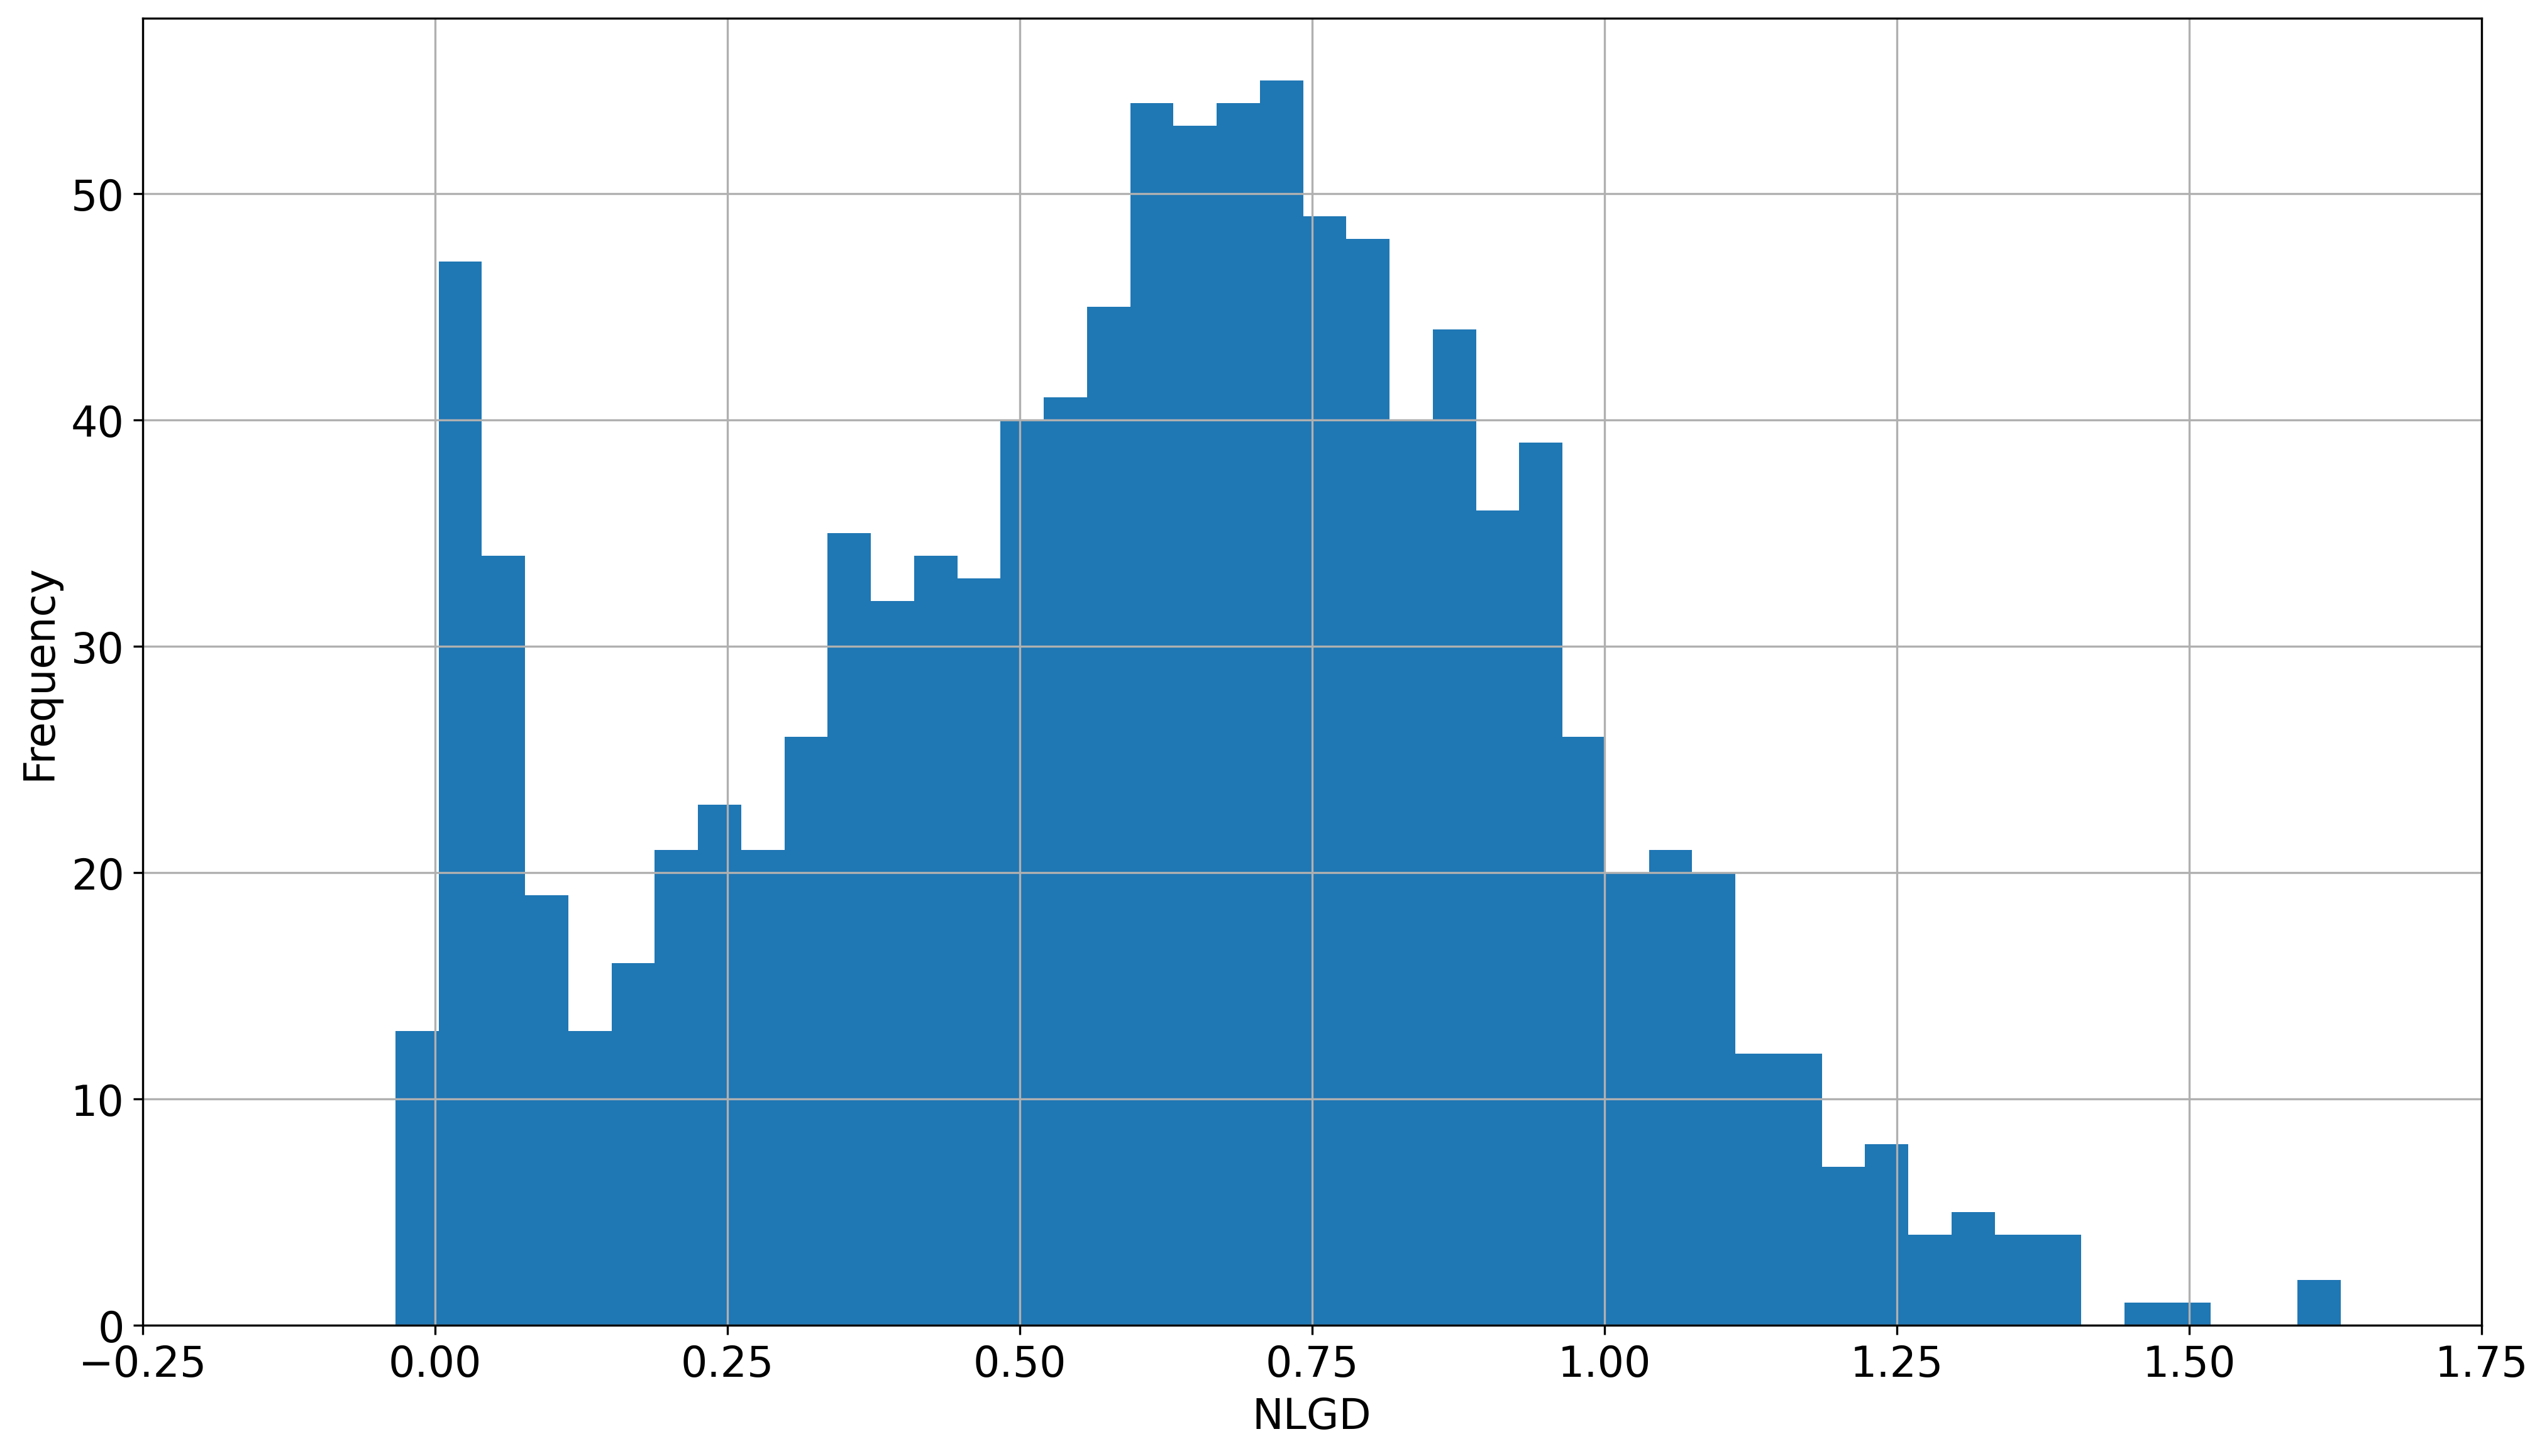

In [26]:
from dcr import xlim

data_default.loc[:,'recovery_res'] = data_default.loc[:,'recovery_res'].astype(float)
data_default.loc[:,'NLGD'] = (data_default.loc[:,'balance_time'] - data_default.loc[:,'recovery_res'] / (1+data_default.loc[:,'rate_time']/(100*4))**data_default.loc[:,'res_period']) / data_default.loc[:,'balance_time']
data_default.NLGD.hist(bins=50)
xlim((-0.25, 1.75))
plt.xlabel('NLGD')
plt.ylabel('Frequency')
plt.show()

In [27]:
print(data_default.NLGD.describe().round(decimals=2))

count    1114.00
mean        0.62
std         0.33
min        -0.03
25%         0.39
50%         0.64
75%         0.84
max         1.81
Name: NLGD, dtype: float64


LGD Winsorizing

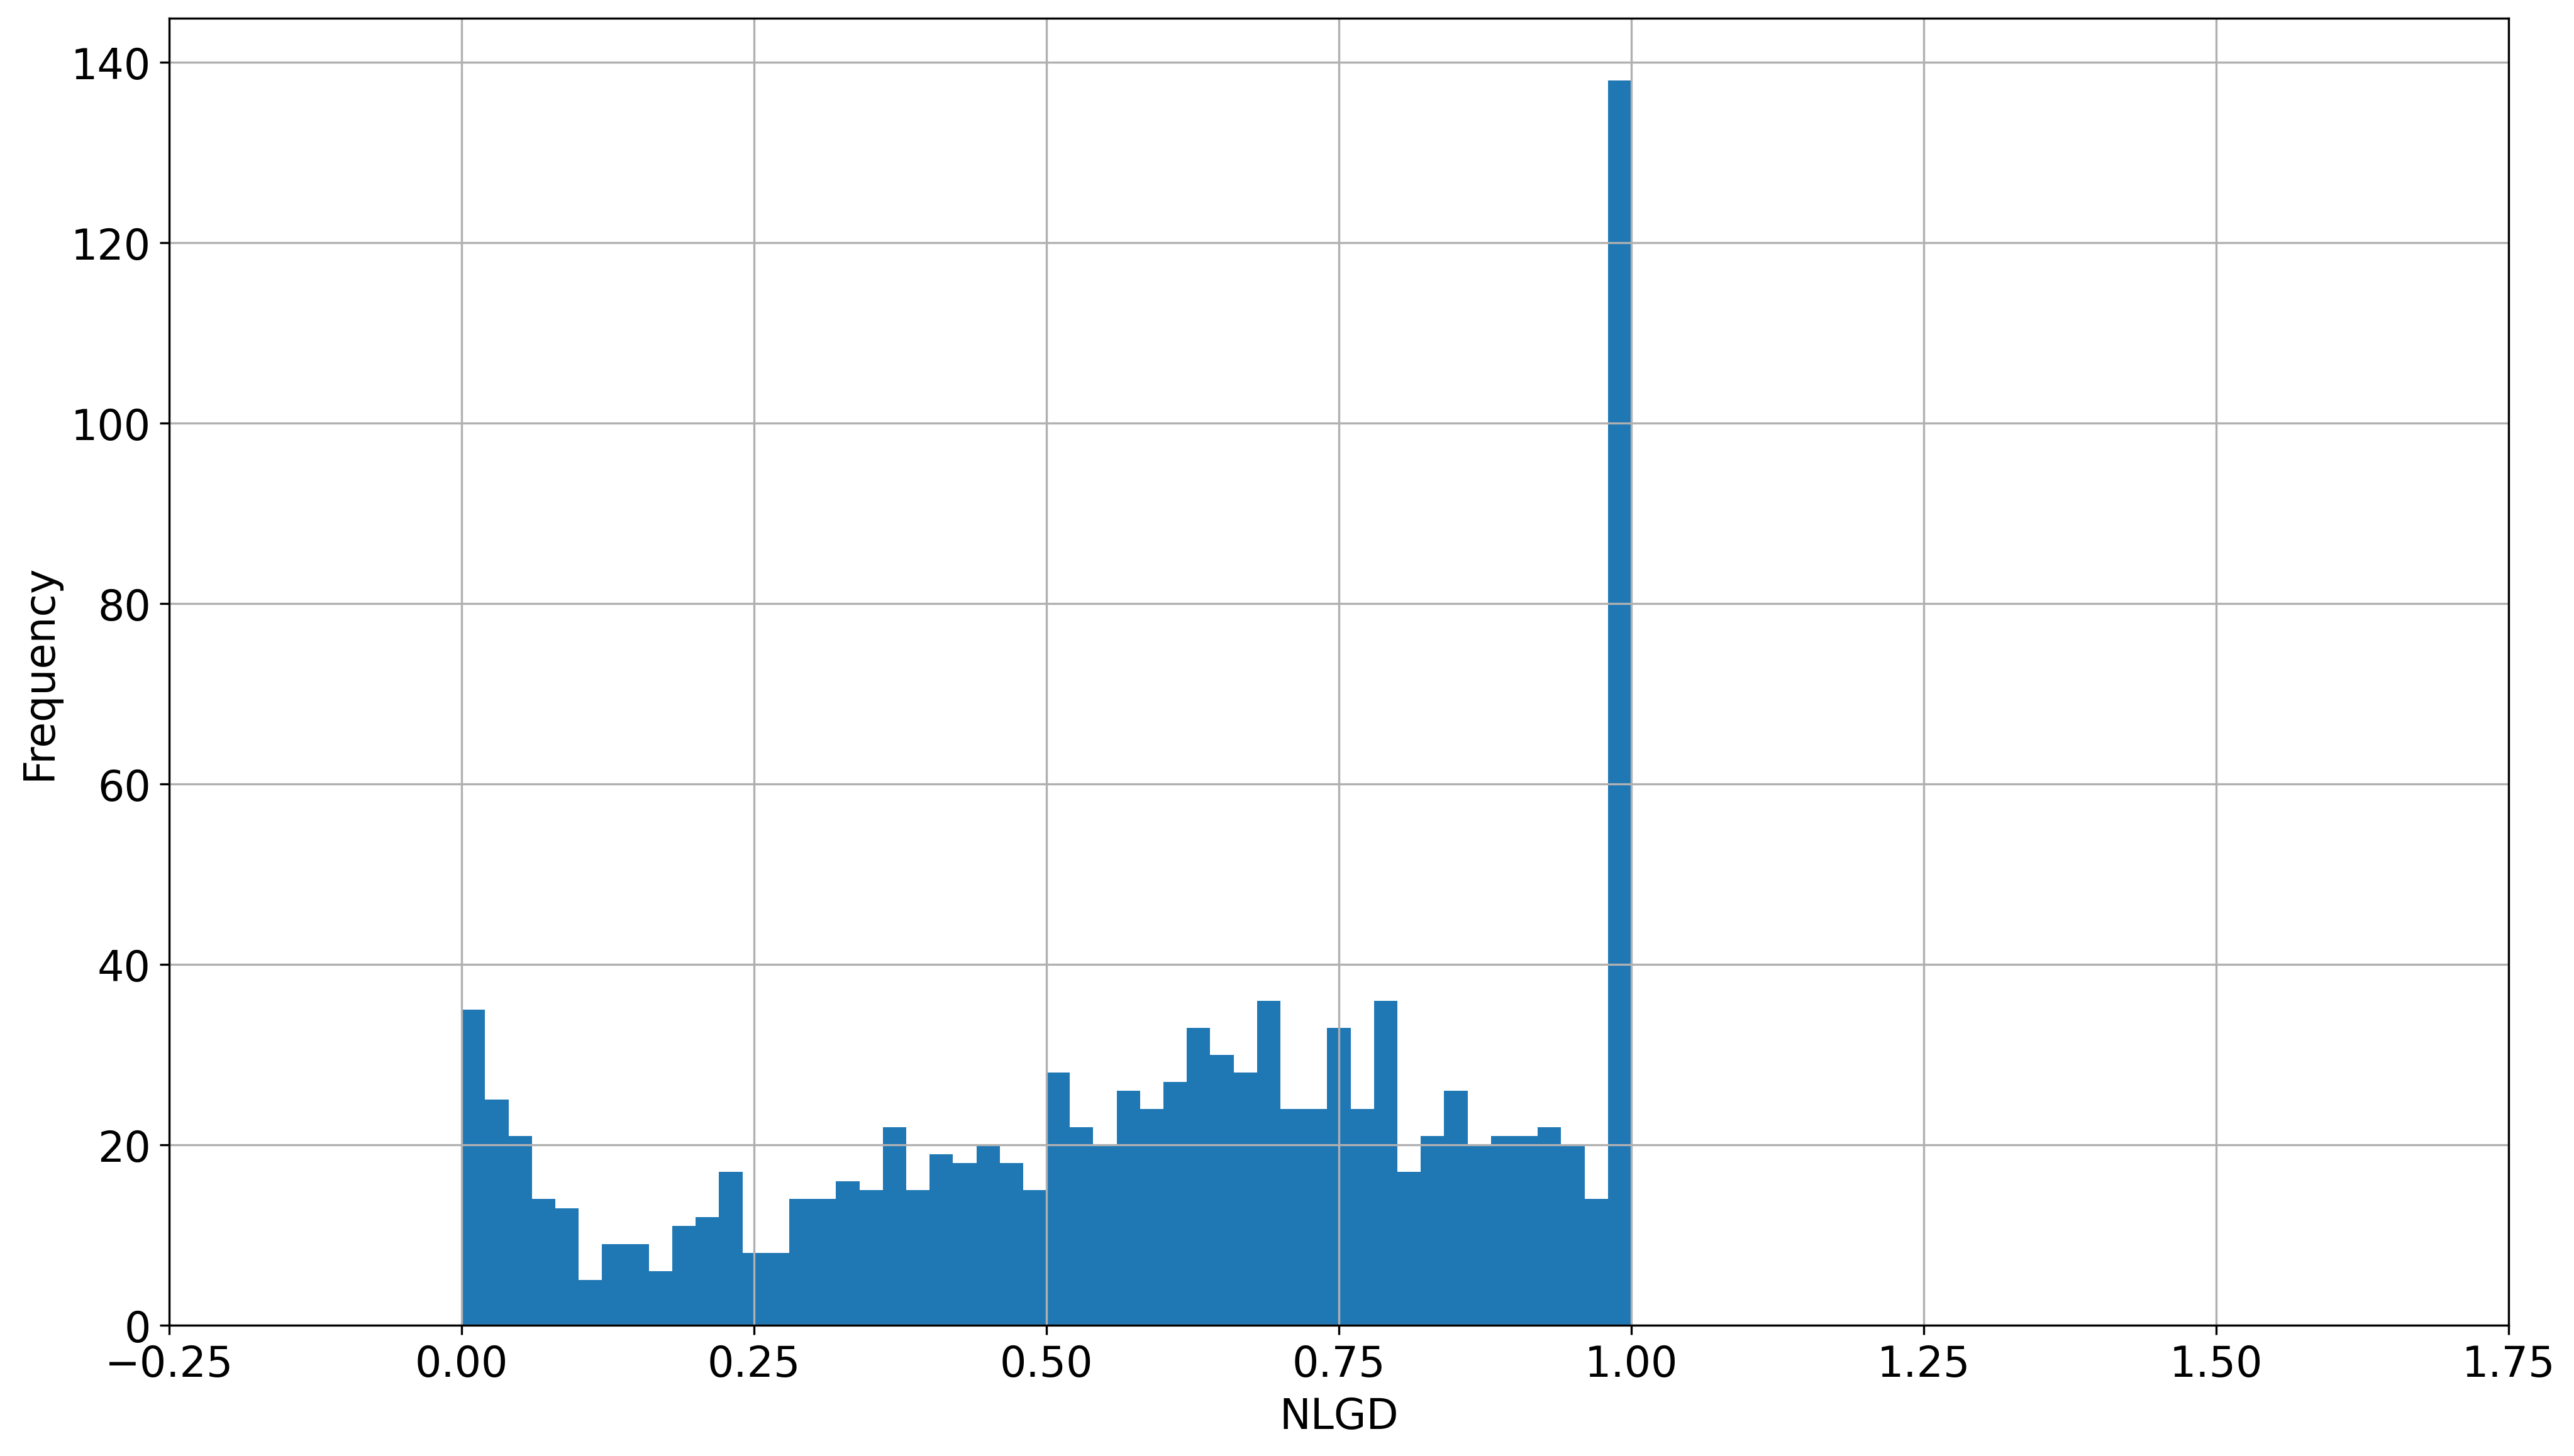

count    1114.00
mean        0.60
std         0.30
min         0.00
25%         0.39
50%         0.64
75%         0.84
max         1.00
Name: NLGD, dtype: float64

In [28]:
data_default.loc[data_default['NLGD'] <= 0, 'NLGD'] = 0.0001
data_default.loc[data_default['NLGD'] >= 1, 'NLGD'] = 0.9999
data_default.NLGD.hist(bins=50)
xlim((-0.25, 1.75))
plt.xlabel('NLGD')
plt.ylabel('Frequency')
plt.show()
data_default.NLGD.describe().round(decimals=2)

Indirect Workout Costs

LGD Discount Rates

## 6 Feature Engineering
pg. 116-150

### Synopsis

### Missing Feature Analysis

### Feature Outlier Analysis

### Scaling

### Non-linear Feature Transformations

### Feature Reduction by Aggregation

### Feature Reduction by Clustering

### Feature Reduction by PCA

### Function `dataprep`

## 7 Feature Selection
pg. 151-170

### Synopsis

### Economic Feature Selection

### Univariate Feature Selection

### Model-based Feature Selection

### Synthesis

## 8 Validation
pg. 171-206

### Synopsis

### Qualitative Validation

### Quantitative Validation

### Metrics for Discriminatory Power

### Metrics for Calibration

### Metrics for Stability

### Function `validation`

### Other Outcomes

### Validation Study